Импортируем все библиотеки

In [1]:
import pandas as pd
from IPython.display import display
pd.options.display.max_columns = None
pd.options.display.max_rows = None
import missingno as msno
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, make_scorer, precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from livelossplot.tf_keras import PlotLossesCallback
import time
from imblearn.over_sampling import SMOTE

Загружаем датасет из csv-файла

In [2]:
df = pd.read_csv('train.csv')
df.head()

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
0,54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,15.0,20.0,0,NaN,употребляю в настоящее время,18.0,22:00:00,06:00:00,0,0,0,54-102-358-02,0,0,0,0,0
1,54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,1,0,0,0,0,0,0,1,0,1,Никогда не курил(а),NaN,NaN,0,NaN,никогда не употреблял,NaN,00:00:00,04:00:00,1,0,0,54-103-101-01,1,1,0,0,0
2,54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,1,1-2 раза в неделю,употребляю в настоящее время,17.0,23:00:00,07:00:00,0,0,0,54-501-026-03,0,0,0,0,0
3,54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,1,0,0,0,0,1,0,0,Бросил(а),12.0,10.0,1,3-6 раз в неделю,употребляю в настоящее время,13.0,23:00:00,07:00:00,0,0,0,54-501-094-02,1,0,0,0,0
4,54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,1,1,1,0,0,0,0,0,1,0,1,Никогда не курил(а),NaN,NaN,1,не менее 1 раза в день,употребляю в настоящее время,16.0,23:00:00,06:00:00,0,0,0,54-503-022-01,1,0,1,1,0


# Почистим данные

Посмотрим, сколько у нас объектов и сколько фичей

In [3]:
print(f'В датасете {df.shape[0]} пациентов и {df.shape[1]} фичей')

В датасете 955 пациентов и 39 фичей


Проверим на пропущенные данные

<AxesSubplot:>

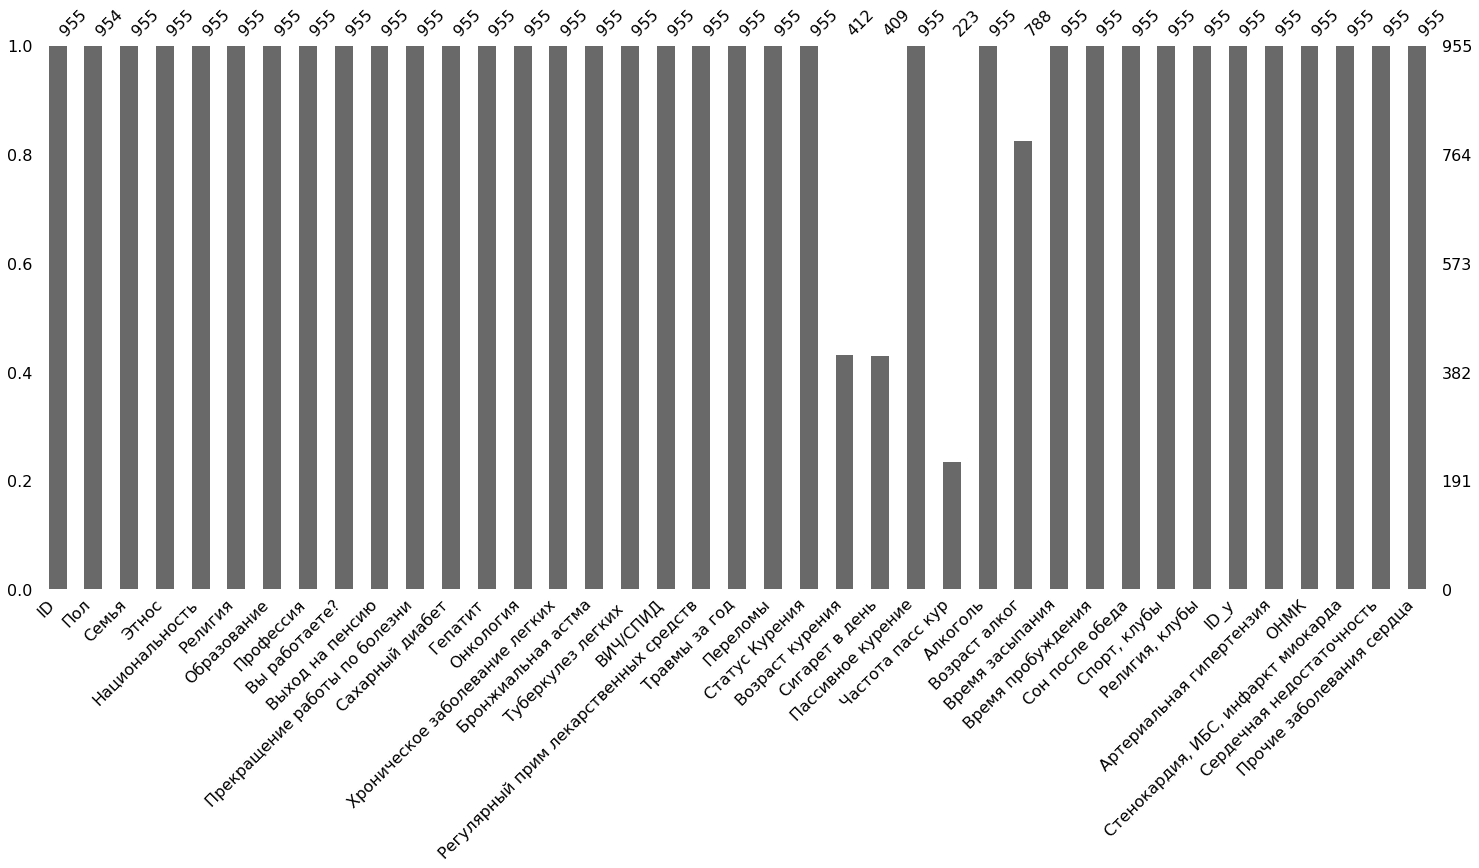

In [4]:
msno.bar(df)

Как мы видим, статус курения указан для всех пациентов. При этом возраст курения указан только для 412 человек. Проверим, соответствует ли это количеству курящих.

In [5]:
df['Статус Курения'].value_counts()

Никогда не курил(а)    543
Курит                  221
Бросил(а)              191
Name: Статус Курения, dtype: int64

221 + 191 = 412. Все правильно. При этом количество сигарет в день указано только для 409 человек. Похоже трое не стали указывать этот параметр. Проверим это

In [6]:
df[(df['Статус Курения'] != 'Никогда не курил(а)') & (df['Сигарет в день'].isna())]\
[['ID', 'Статус Курения', 'Возраст курения', 'Сигарет в день']]

,ID,Статус Курения,Возраст курения,Сигарет в день
123,54-102-244-02,Бросил(а),18.0,NaN
354,54-601-015-02,Курит,25.0,NaN
886,54-602-038-01,Курит,52.0,NaN


Удалим этих троих из датасета

In [7]:
df = df[~df['ID'].isin(['54-102-244-02', '54-601-015-02', '54-602-038-01'])]
df.shape

(952, 39)

Аналогично проверим соответствие количества пассивно курящих и количества указавших частоту пассивного курения.

In [8]:
df['Пассивное курение'].value_counts()

0    728
1    224
Name: Пассивное курение, dtype: int64

Пассивно курят 224 человека, а частоту указали 223. Посмотрим, кто не указал.

In [9]:
df[(df['Пассивное курение'] == 1) & (df['Частота пасс кур'].isna())]\
[['ID', 'Пассивное курение', 'Частота пасс кур']]

,ID,Пассивное курение,Частота пасс кур
175,54-102-340-01,1,NaN
247,54-701-024-02,1,NaN


Оказывается, частоту курения не указали двое из 224 пассивно курящих. Значит еще один человек дал неверные сведения - что он не курит пассивно, но при этом указал частоту. Проверим.

In [10]:
df[(df['Пассивное курение'] == 0) & (df['Частота пасс кур'].isna() == False)]\
[['ID', 'Пассивное курение', 'Частота пасс кур']]

,ID,Пассивное курение,Частота пасс кур
392,54-001-079-01,0,3-6 раз в неделю


Удалим и этих троих

In [11]:
df = df[~df['ID'].isin(['54-102-340-01', '54-701-024-02', '54-001-079-01'])]
df.shape

(949, 39)

Осталось разобраться с алкоголиками

In [12]:
df['Алкоголь'].value_counts()

употребляю в настоящее время    630
никогда не употреблял           165
ранее употреблял                154
Name: Алкоголь, dtype: int64

634 + 156 = 790 человек употребляют или употребляли алкоголь, а длительность периода приема указали 788. Проверим это соответствие.

In [13]:
df[(df['Алкоголь'] != 'никогда не употреблял') & (df['Возраст алког'].isna())]\
[['ID', 'Алкоголь', 'Возраст алког']]

,ID,Алкоголь,Возраст алког
451,54-102-238-02,употребляю в настоящее время,NaN
545,54-701-032-01,употребляю в настоящее время,NaN


Действительно, двое из пьющих не указали период приема алкоголя. Убираем их из основного датафрейма.

In [14]:
df = df[~df['ID'].isin(['54-102-238-02', '54-701-032-01'])]
df.shape

(947, 39)

Также в столбце "Пол" отсутствует одно значение.

In [15]:
df[df['Пол'].isin(['М', 'Ж']) == False]

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",ID_y,Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца
304,54-701-009-01,NaN,гражданский брак / проживание с партнером,европейская,Русские,Нет,3 - средняя школа / закон.среднее / выше среднего,"работники, занятые в сфере обслуживания, торг...",1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,18.0,3.0,0,NaN,употребляю в настоящее время,20.0,01:00:00,06:30:00,0,0,0,54-701-009-01,0,0,0,0,0


Удалим и этого товарища

In [16]:
df = df[df['ID'] != '54-701-009-01']
df.shape

(946, 39)

Проверку правильности предсказаний мы должы провести на тестовом датасете 'test_dataset_test'. Значит надо проверить - соответствует ли его форма и значения тренировочному датасету, чтобы в дальнейшем подавать на вход классификатора одинаковые данные. Загрузим его.

In [17]:
test_df = pd.read_csv('test_dataset_test.csv')
test_df.head()

,ID,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы"
0,54-001-019-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,ремесленники и представители других отраслей п...,1,0,0,0,0,0,0,0,0,0,1,1,1,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,23.0,21:30:00,05:00:00,0,1,1
1,54-002-133-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,22.0,00:00:00,09:00:00,0,0,0
2,54-001-007-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,0,NaN,употребляю в настоящее время,18.0,23:00:00,07:30:00,0,0,0
3,54-102-116-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,низкоквалифицированные работники,1,0,0,0,1,0,0,0,0,0,0,0,1,Никогда не курил(а),NaN,NaN,0,NaN,никогда не употреблял,NaN,22:00:00,06:00:00,0,0,0
4,54-502-005-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,1,0,0,0,0,0,0,0,0,1,1,1,Курит,14.0,20.0,0,NaN,употребляю в настоящее время,19.0,22:00:00,06:00:00,0,0,0


Создадим список совпадающих названий столбцов и затем проверим какие столбцы из тренировочного и тестового датасета в него не входят

In [18]:
same_columns = list(set(list(df.columns)) & set(list(test_df.columns)))

Не общие столбцы тренировочного датасета

In [19]:
list(set(list(df.columns)) - set(same_columns))

['ОНМК',
 'Сердечная недостаточность',
 'ID_y',
 'Прочие заболевания сердца',
 'Артериальная гипертензия',
 'Стенокардия, ИБС, инфаркт миокарда']

Не общие столбцы тестового датасета

In [20]:
list(set(list(test_df.columns)) - set(same_columns))

[]

Все отлично. В тестовом сете и не должно быть пяти столбцов с признаками, которые нам как раз надо предсказать. А вот столбец ID_y лишний. Проверим, одинаковы ли значения в столбцах 'ID' и 'ID_y'

In [21]:
df[df[['ID','ID_y']].nunique(axis=1) == 0].shape

(0, 39)

Эти столбцы абсолютно идентичны. Удалим 'ID_y', а 'ID' сделаем индексом в обоих датафреймах.

In [22]:
df = df.drop(['ID_y'], axis = 1)
df = df.set_index('ID')
test_df = test_df.set_index('ID')

Теперь давайте внимательно посмотрим на содержание строковых столбцов.

In [23]:
df.describe(include=[object])

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Статус Курения,Частота пасс кур,Алкоголь,Время засыпания,Время пробуждения
count,946,946,946,946,946,946,946,946,222,946,946,946
unique,2,6,3,18,4,4,11,3,5,3,22,34
top,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,дипломированные специалисты,Никогда не курил(а),1-2 раза в неделю,употребляю в настоящее время,23:00:00,06:00:00
freq,664,557,922,890,797,452,224,541,92,627,310,231


In [24]:
test_df.describe(include=[object])

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Статус Курения,Частота пасс кур,Алкоголь,Время засыпания,Время пробуждения
count,638,638,638,638,638,638,638,638,154,638,638,638
unique,2,6,3,11,6,4,11,4,5,3,22,31
top,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,дипломированные специалисты,Никогда не курил(а),1-2 раза в неделю,употребляю в настоящее время,23:00:00,06:00:00
freq,450,374,628,601,557,303,157,368,66,412,207,163


Мы уже видим несоответствие количества уникальных элементов одинаковых столбцов в наших датасетах. Давайте объединим их и выведем названия столбцов с несовпадениями.

In [25]:
features_1 = df.describe(include=[object]).T.reset_index()
features_2 = test_df.describe(include=[object]).T.reset_index()

In [26]:
same_values_features = list(pd.merge(features_1, features_2, on = ['unique', 'index'])['index'])

In [27]:
pd.merge(features_1[~features_1['index'].isin(same_values_features)],\
         features_2[~features_2['index'].isin(same_values_features)],\
                    on = ['index'])

,index,count_x,unique_x,top_x,freq_x,count_y,unique_y,top_y,freq_y
0,Национальность,946,18,Русские,890,638,11,Русские,601
1,Религия,946,4,Христианство,797,638,6,Христианство,557
2,Статус Курения,946,3,Никогда не курил(а),541,638,4,Никогда не курил(а),368
3,Время пробуждения,946,34,06:00:00,231,638,31,06:00:00,163


Итак, 4 столбца имеют неидентичный набор данных. Давайте устраним это. Начнем со столбца "Национальность".

Посмотрим списки значений этого столбца для обоих датафреймов

In [28]:
df['Национальность'].unique()

array(['Русские', 'Азербайджанцы', 'Татары', 'Немцы', 'Эстонцы',
       'Другие национальности', 'Молдаване', 'Украинцы', 'Чуваши',
       'Мордва', 'Киргизы', 'Казахи', 'Армяне', 'Белорусы', 'Таджики',
       'Башкиры', 'Евреи', 'Буряты'], dtype=object)

In [29]:
test_df['Национальность'].unique()

array(['Русские', 'Украинцы', 'Татары', 'Другие национальности', 'Чуваши',
       'Немцы', 'Белорусы', 'Армяне', 'Удмурты', 'Казахи', 'Лезгины'],
      dtype=object)

Все совпадающие национальности оставим, а несовпадающие занесем в категорию "Другие национальности"

In [30]:
test_df.loc[(test_df['Национальность'] == 'Удмурты') | (test_df['Национальность'] == 'Лезгины'),\
            'Национальность'] = 'Другие национальности'

In [31]:
df.loc[~df['Национальность'].isin(list(test_df['Национальность'].unique())),\
            'Национальность'] = 'Другие национальности'

Теперь взглянем на столбец "Религия"

In [32]:
df['Религия'].unique()

array(['Христианство', 'Атеист / агностик', 'Ислам', 'Нет'], dtype=object)

In [33]:
test_df['Религия'].unique()

array(['Христианство', 'Атеист / агностик', 'Нет', 'Ислам', 'Другое',
       'Индуизм'], dtype=object)

К сожалению два значения - "Другое" и "Индуизм" - из тестового сета придется убрать, так как в тренировочном сете их нет и модель не будет знать, как себя с ними вести. Придется записать их в категорию "Нет" как наиболее логически подходящую. Это, конечно, внесет некоторую долю ошибки и понизит точность предсказания, но совсем убрать эти строки мы не можем по условию. Давайте хотя бы глянем, сколько этих строк

In [34]:
test_df.loc[test_df['Религия'].isin(['Другое', 'Индуизм'])]

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы"
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54-102-229-01,Ж,вдовец / вдова,европейская,Русские,Другое,4 - профессиональное училище,техники и младшие специалисты,0,1,0,1,0,1,0,0,0,0,1,0,0,Никогда не курил(а),NaN,NaN,0,NaN,ранее употреблял,17.0,21:00:00,06:00:00,0,0,1
54-504-023-02,М,в браке в настоящее время,европейская,Русские,Индуизм,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,0,0,1,Бросил(а),17.0,20.0,0,NaN,употребляю в настоящее время,17.0,22:00:00,09:00:00,0,0,0


Слава Богу, всего две строки. Сильно их трансформация ничего не изменит

In [35]:
test_df.loc[(test_df['Религия'] == 'Другое') | (test_df['Религия'] == 'Индуизм'),\
            'Религия'] = 'Нет'

Теперь проверим "Статус курения"

In [36]:
df['Статус Курения'].unique()

array(['Курит', 'Никогда не курил(а)', 'Бросил(а)'], dtype=object)

In [37]:
test_df['Статус Курения'].unique()

array(['Никогда не курил(а)', 'Курит', 'Бросил(а)', 'Никогда не курил'],
      dtype=object)

Здесь элементарно не дописана буква (а). Исправим это

In [38]:
test_df.loc[(test_df['Статус Курения'] == 'Никогда не курил'),\
            'Статус Курения'] = 'Никогда не курил(а)'

Ну а количество уникальных значений времени пробуждения и не должны совпадать.

Проверим типы столбцов

In [39]:
df.dtypes, test_df.dtypes

(Пол                                       object
 Семья                                     object
 Этнос                                     object
 Национальность                            object
 Религия                                   object
 Образование                               object
 Профессия                                 object
 Вы работаете?                              int64
 Выход на пенсию                            int64
 Прекращение работы по болезни              int64
 Сахарный диабет                            int64
 Гепатит                                    int64
 Онкология                                  int64
 Хроническое заболевание легких             int64
 Бронжиальная астма                         int64
 Туберкулез легких                          int64
 ВИЧ/СПИД                                   int64
 Регулярный прим лекарственных средств      int64
 Травмы за год                              int64
 Переломы                                   int64


Приведем столбцы "Время засыпания" и "Время пробуждения" к типу даты и времени.

In [40]:
df[['Время засыпания', 'Время пробуждения']] = df[['Время засыпания', 'Время пробуждения']].astype('datetime64')
test_df[['Время засыпания', 'Время пробуждения']] = test_df[['Время засыпания', 'Время пробуждения']].astype('datetime64')
df[['Время засыпания', 'Время пробуждения']].dtypes, test_df[['Время засыпания', 'Время пробуждения']].dtypes

(Время засыпания      datetime64[ns]
 Время пробуждения    datetime64[ns]
 dtype: object,
 Время засыпания      datetime64[ns]
 Время пробуждения    datetime64[ns]
 dtype: object)

Введём новый столбец - "Время сна". Он тоже может влиять на целевые показатели

In [41]:
df['Время сна'] = df['Время пробуждения'] - df['Время засыпания']
test_df['Время сна'] = test_df['Время пробуждения'] - test_df['Время засыпания']

In [42]:
def sleep_time(x):
    x = int(x.total_seconds()) // 3600
    if x < 0:
        x += 24
    return x
df['Время сна'] = df['Время сна'].apply(lambda x: sleep_time(x))
test_df['Время сна'] = test_df['Время сна'].apply(lambda x: sleep_time(x))

Проверим достоверность полученных данных

In [43]:
df['Время сна'].value_counts(), test_df['Время сна'].value_counts()

(7     284
 8     249
 9     138
 6     132
 10     62
 5      39
 11     15
 4      14
 12      6
 3       3
 13      2
 19      1
 0       1
 Name: Время сна, dtype: int64,
 8     201
 7     170
 6      98
 9      73
 10     31
 5      26
 11     17
 4       8
 12      5
 3       5
 0       3
 21      1
 Name: Время сна, dtype: int64)

Так как время засыпания и пробуждения пациенты указывали в среднем для определенного периода, а не для одного какого-то дня, то показатель времени сна в 19 часов каждый день явно неправдоподобен. Такой пациент один. Давайте лучше удалим его, чтобы он не вносил погрешность в наши исследования. Также совсем неправдоподобен ответ 21 час - но строку из тестовых данных мы не можем убрать по условию.

In [44]:
df[df['Время сна'] == 19][['Время засыпания', 'Время пробуждения']]

,Время засыпания,Время пробуждения
ID,,
54-002-054-02,2022-07-09 12:00:00,2022-07-09 07:00:00


Действительно маловероятно засыпать в 12 и просыпаться в 7 каждый день. Удаляем.

In [45]:
df = df[df['Время сна'] != 19]

Три столбца имеют тип float, хотя по сути это целые числа. Это связано с наличием NaN-значений. В данном случае их все можно заменить нулями, и привести столбцы к типу int. При этом также заменятся нулями значения NaN в столбце "Частота пасс кур", и ноль запишется как строка, но это не страшно.

In [46]:
df = df.fillna(0)
df[['Возраст курения', 'Сигарет в день', 'Возраст алког']] =\
df[['Возраст курения', 'Сигарет в день', 'Возраст алког']].astype('int64')
test_df = test_df.fillna(0)
test_df[['Возраст курения', 'Сигарет в день', 'Возраст алког']] =\
test_df[['Возраст курения', 'Сигарет в день', 'Возраст алког']].astype('int64')

Посмотрим на все возможные значения строковых столбцов

In [47]:
for col in list(df.describe(include=[object]).columns):
    print(f'Значения столбца "{col}": ', end = '')
    for i, elem in enumerate(df[col].unique()):
        if (i == len(df[col].unique()) - 1):
            print(elem)
        else:
            print(elem, end = ', ')
    print(100 * '-')

Значения столбца "Пол": М, Ж
----------------------------------------------------------------------------------------------------
Значения столбца "Семья": в браке в настоящее время, в разводе, гражданский брак / проживание с партнером, вдовец / вдова, никогда не был(а) в браке, раздельное проживание (официально не разведены)
----------------------------------------------------------------------------------------------------
Значения столбца "Этнос": европейская, другая азиатская (Корея, Малайзия, Таиланд, Вьетнам, Казахстан, Киргизия, Туркмения, Узбекистан, Таджикистан), прочее (любая иная этно-расовая группа, не представленная выше)
----------------------------------------------------------------------------------------------------
Значения столбца "Национальность": Русские, Другие национальности, Татары, Немцы, Украинцы, Чуваши, Казахи, Армяне, Белорусы
----------------------------------------------------------------------------------------------------
Значения столбца "Религия": Хр

In [48]:
for col in list(test_df.describe(include=[object]).columns):
    print(f'Значения столбца "{col}": ', end = '')
    for i, elem in enumerate(test_df[col].unique()):
        if (i == len(test_df[col].unique()) - 1):
            print(elem)
        else:
            print(elem, end = ', ')
    print(100 * '-')

Значения столбца "Пол": Ж, М
----------------------------------------------------------------------------------------------------
Значения столбца "Семья": вдовец / вдова, в разводе, в браке в настоящее время, никогда не был(а) в браке, гражданский брак / проживание с партнером, раздельное проживание (официально не разведены)
----------------------------------------------------------------------------------------------------
Значения столбца "Этнос": европейская, другая азиатская (Корея, Малайзия, Таиланд, Вьетнам, Казахстан, Киргизия, Туркмения, Узбекистан, Таджикистан), прочее (любая иная этно-расовая группа, не представленная выше)
----------------------------------------------------------------------------------------------------
Значения столбца "Национальность": Русские, Украинцы, Татары, Другие национальности, Чуваши, Немцы, Белорусы, Армяне, Казахи
----------------------------------------------------------------------------------------------------
Значения столбца "Религия": Хр

Все совпадает. Идем дальше

# Исследование зависимостей и формулирование гипотез

Предварительно надо ранжировать все категориальные признаки. Для этого признаки, имеющие две категории, закодируем с помощью метода доступа cat.codes, а признаки с числом категорий более двух - с помощью one-hot encoding.

Но предварительно создадим дополнительные категориальные столбцы из числовых столбцов с небинарными данными путем разбивки диапазона допустимых значений таких столбцов на интервалы и причисления каждого значения к одному из таких интервалов.

In [49]:
interval_list = np.arange(0, 101, 5)
df['Возраст курения'] = pd.cut(df['Возраст курения'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)
test_df['Возраст курения'] = pd.cut(test_df['Возраст курения'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)

In [50]:
df['Возраст алког'] = pd.cut(df['Возраст алког'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)
test_df['Возраст алког'] = pd.cut(test_df['Возраст алког'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)

In [51]:
interval_list = np.arange(0, 25, 3)
df['Время засыпания'] = df['Время засыпания'].apply(lambda x: x.hour)
test_df['Время засыпания'] = test_df['Время засыпания'].apply(lambda x: x.hour)
df['Время засыпания'] = pd.cut(df['Время засыпания'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)
test_df['Время засыпания'] = pd.cut(test_df['Время засыпания'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)

In [52]:
df['Время пробуждения'] = df['Время пробуждения'].apply(lambda x: x.hour)
test_df['Время пробуждения'] = test_df['Время пробуждения'].apply(lambda x: x.hour)
df['Время пробуждения'] = pd.cut(df['Время пробуждения'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)
test_df['Время пробуждения'] = pd.cut(test_df['Время пробуждения'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)

In [53]:
df['Время сна'] = pd.cut(df['Время сна'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)
test_df['Время сна'] = pd.cut(test_df['Время сна'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)

In [54]:
interval_list = list(np.arange(0, 101, 10))
interval_list.append(1000)
df['Сигарет в день'] = pd.cut(df['Сигарет в день'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)
test_df['Сигарет в день'] = pd.cut(test_df['Сигарет в день'],
                       bins=interval_list,
                       labels=[f'От {interval_list[i]} до {interval_list[i+1]}' for i in range(len(interval_list) - 1)],\
                              include_lowest = True)

Посмотрим, что у нас получилось

In [55]:
df.head()

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Артериальная гипертензия,ОНМК,"Стенокардия, ИБС, инфаркт миокарда",Сердечная недостаточность,Прочие заболевания сердца,Время сна
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54-102-358-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,0,0,0,0,0,0,0,0,Курит,От 10 до 15,От 10 до 20,0,0,употребляю в настоящее время,От 15 до 20,От 21 до 24,От 3 до 6,0,0,0,0,0,0,0,0,От 6 до 9
54-103-101-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,1,0,0,0,0,0,0,1,0,1,Никогда не курил(а),От 0 до 5,От 0 до 10,0,0,никогда не употреблял,От 0 до 5,От 0 до 3,От 3 до 6,1,0,0,1,1,0,0,0,От 3 до 6
54-501-026-03,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,0,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),От 0 до 5,От 0 до 10,1,1-2 раза в неделю,употребляю в настоящее время,От 15 до 20,От 21 до 24,От 6 до 9,0,0,0,0,0,0,0,0,От 6 до 9
54-501-094-02,М,в браке в настоящее время,европейская,Русские,Атеист / агностик,3 - средняя школа / закон.среднее / выше среднего,низкоквалифицированные работники,1,0,0,0,0,1,0,0,0,0,1,0,0,Бросил(а),От 10 до 15,От 0 до 10,1,3-6 раз в неделю,употребляю в настоящее время,От 10 до 15,От 21 до 24,От 6 до 9,0,0,0,1,0,0,0,0,От 6 до 9
54-503-022-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,0,1,1,1,0,0,0,0,0,1,0,1,Никогда не курил(а),От 0 до 5,От 0 до 10,1,не менее 1 раза в день,употребляю в настоящее время,От 15 до 20,От 21 до 24,От 3 до 6,0,0,0,1,0,1,1,0,От 6 до 9


In [56]:
test_df.head()

,Пол,Семья,Этнос,Национальность,Религия,Образование,Профессия,Вы работаете?,Выход на пенсию,Прекращение работы по болезни,Сахарный диабет,Гепатит,Онкология,Хроническое заболевание легких,Бронжиальная астма,Туберкулез легких,ВИЧ/СПИД,Регулярный прим лекарственных средств,Травмы за год,Переломы,Статус Курения,Возраст курения,Сигарет в день,Пассивное курение,Частота пасс кур,Алкоголь,Возраст алког,Время засыпания,Время пробуждения,Сон после обеда,"Спорт, клубы","Религия, клубы",Время сна
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
54-001-019-01,Ж,вдовец / вдова,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,ремесленники и представители других отраслей п...,1,0,0,0,0,0,0,0,0,0,1,1,1,Никогда не курил(а),От 0 до 5,От 0 до 10,0,0,употребляю в настоящее время,От 20 до 25,От 18 до 21,От 3 до 6,0,1,1,От 6 до 9
54-002-133-01,Ж,в разводе,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),От 0 до 5,От 0 до 10,0,0,употребляю в настоящее время,От 20 до 25,От 0 до 3,От 6 до 9,0,0,0,От 6 до 9
54-001-007-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,5 - ВУЗ,дипломированные специалисты,0,1,0,0,0,0,0,0,0,0,1,0,0,Никогда не курил(а),От 0 до 5,От 0 до 10,0,0,употребляю в настоящее время,От 15 до 20,От 21 до 24,От 6 до 9,0,0,0,От 6 до 9
54-102-116-01,Ж,в браке в настоящее время,европейская,Русские,Христианство,4 - профессиональное училище,низкоквалифицированные работники,1,0,0,0,1,0,0,0,0,0,0,0,1,Никогда не курил(а),От 0 до 5,От 0 до 10,0,0,никогда не употреблял,От 0 до 5,От 21 до 24,От 3 до 6,0,0,0,От 6 до 9
54-502-005-02,М,в браке в настоящее время,европейская,Русские,Христианство,3 - средняя школа / закон.среднее / выше среднего,операторы и монтажники установок и машинного о...,0,1,0,0,0,0,0,0,0,0,1,1,1,Курит,От 10 до 15,От 10 до 20,0,0,употребляю в настоящее время,От 15 до 20,От 21 до 24,От 3 до 6,0,0,0,От 6 до 9


Вот теперь ранжируем категориальные столбцы

In [57]:
print(f'В столбце "Пол":  ', end = '')
cat_col = df['Пол'].astype('category')
codes = cat_col.cat.codes
cats = cat_col.cat.categories
df.loc[:, 'Пол'] = codes
print(f'{cats[0]} --> 0,  ', end = '')
print(f'{cats[1]} --> 1.')               

В столбце "Пол":  Ж --> 0,  М --> 1.


In [58]:
print(f'В столбце "Пол":  ', end = '')
cat_col = test_df['Пол'].astype('category')
codes = cat_col.cat.codes
cats = cat_col.cat.categories
test_df.loc[:, 'Пол'] = codes
print(f'{cats[0]} --> 0,  ', end = '')
print(f'{cats[1]} --> 1.')

В столбце "Пол":  Ж --> 0,  М --> 1.


In [59]:
df = pd.get_dummies(df)
test_df = pd.get_dummies(test_df)

Проверим совпадение количества фич в тестовом и тренировочном датасетах (в тестовом должно быть на 5 меньше)

In [60]:
df.shape, test_df.shape

((945, 147), (638, 142))

# Построение гипотез

Для построения пайплайнов обучения классификаторов построим корреляционную таблицу для вычисления связей между признаками и целевыми фичами. Используем все три коэффициента - Кендалла, Спирмана и Пирсона.

In [61]:
corr_1 = df.corr(method='kendall')[['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда',\
                                  'Сердечная недостаточность', 'Прочие заболевания сердца']].rename(columns =\
                                    {'Артериальная гипертензия':'АГ1', 'ОНМК':'ОНМК1', 'Стенокардия, ИБС, инфаркт миокарда':\
                                    'СК1, ИБС1, ИМ1', 'Сердечная недостаточность':'СН1', 'Прочие заболевания сердца':\
                                    'ПЗС1'})
corr_2 = df.corr(method='spearman')[['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда',\
                                  'Сердечная недостаточность', 'Прочие заболевания сердца']].rename(columns =\
                                    {'Артериальная гипертензия':'АГ2', 'ОНМК':'ОНМК2', 'Стенокардия, ИБС, инфаркт миокарда':\
                                    'СК2, ИБС2, ИМ2', 'Сердечная недостаточность':'СН2', 'Прочие заболевания сердца':\
                                    'ПЗС2'})
corr_3 = df.corr(method='pearson')[['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда',\
                                  'Сердечная недостаточность', 'Прочие заболевания сердца']].rename(columns =\
                                    {'Артериальная гипертензия':'АГ3', 'ОНМК':'ОНМК3', 'Стенокардия, ИБС, инфаркт миокарда':\
                                    'СК3, ИБС3, ИМ3', 'Сердечная недостаточность':'СН3', 'Прочие заболевания сердца':\
                                    'ПЗС3'})
corr_df = pd.concat([corr_1, corr_2, corr_3], axis=1)
corr_df = corr_df.fillna(0)
corr_df

,АГ1,ОНМК1,"СК1, ИБС1, ИМ1",СН1,ПЗС1,АГ2,ОНМК2,"СК2, ИБС2, ИМ2",СН2,ПЗС2,АГ3,ОНМК3,"СК3, ИБС3, ИМ3",СН3,ПЗС3
Пол,-0.124549,0.081706,0.008502,-0.080815,-0.083143,-0.124549,0.081706,0.008502,-0.080815,-0.083143,-0.124549,0.081706,0.008502,-0.080815,-0.083143
Вы работаете?,-0.224903,-0.073618,-0.208513,-0.178072,-0.056391,-0.224903,-0.073618,-0.208513,-0.178072,-0.056391,-0.224903,-0.073618,-0.208513,-0.178072,-0.056391
Выход на пенсию,0.255625,0.050496,0.221858,0.175653,0.026589,0.255625,0.050496,0.221858,0.175653,0.026589,0.255625,0.050496,0.221858,0.175653,0.026589
Прекращение работы по болезни,0.035373,0.103213,0.084667,0.058688,0.035852,0.035373,0.103213,0.084667,0.058688,0.035852,0.035373,0.103213,0.084667,0.058688,0.035852
Сахарный диабет,0.230615,0.047281,0.142247,0.100677,0.036135,0.230615,0.047281,0.142247,0.100677,0.036135,0.230615,0.047281,0.142247,0.100677,0.036135
Гепатит,-0.036704,-0.028883,-0.019710,0.005620,-0.013269,-0.036704,-0.028883,-0.019710,0.005620,-0.013269,-0.036704,-0.028883,-0.019710,0.005620,-0.013269
Онкология,0.086929,0.005668,0.043653,0.046459,0.057831,0.086929,0.005668,0.043653,0.046459,0.057831,0.086929,0.005668,0.043653,0.046459,0.057831
Хроническое заболевание легких,0.067778,-0.000943,0.001038,0.048662,0.063067,0.067778,-0.000943,0.001038,0.048662,0.063067,0.067778,-0.000943,0.001038,0.048662,0.063067
Бронжиальная астма,0.092782,-0.044773,0.046110,0.100323,0.023822,0.092782,-0.044773,0.046110,0.100323,0.023822,0.092782,-0.044773,0.046110,0.100323,0.023822
Туберкулез легких,0.024877,-0.030914,0.078659,0.047900,0.005167,0.024877,-0.030914,0.078659,0.047900,0.005167,0.024877,-0.030914,0.078659,0.047900,0.005167


Выберем пороги коэффициента корреляции. Для этого составим таблицу, в каждой строке которой будет записан список признаков и соответствующий им порог для каждой целевой фичи. Этот порог является максимальным значением коэффициента корреляции соответствующей строки в таблице корреляции corr_df. То есть это означает, что все корреляции с целевыми показателями для данного списка признаков имеют коэффициент корреляции не выше указанного. То есть, например, для Артериальной гипертензии берем столбцы АГ1, АГ2 и АГ3. Перебираем значения коэффициента с шагом 0.0001 и сравниваем все три столбца с этим значением - таким образом для каждой фичи находим порог, который не превышают значения всех трех столбцов.

**Для признака Артериальная гипертензия**

In [62]:
temp = corr_df[['АГ1', 'АГ2', 'АГ3']]
min_corr = 0.0001
corr_dict = dict()
while len(temp) != 0:
    temp_2 = temp.copy()
    temp_2['summ'] = temp_2.applymap(lambda x: 1 if abs(x) <= min_corr else 0).sum(axis = 1)
    temp = temp_2[temp_2['summ'] != 3]
    temp_2 = temp_2[temp_2['summ'] == 3]
    if len(temp_2) != 0:
        corr_dict[tuple(temp_2.index)] = min_corr
    min_corr += 0.0001
features_df = pd.DataFrame([corr_dict]).T.rename(columns={0:'Коэффициент корреляции'})
features_df

,Коэффициент корреляции
"(Возраст курения_От 60 до 65, Возраст курения_От 65 до 70, Возраст курения_От 70 до 75, Возраст курения_От 75 до 80, Возраст курения_От 80 до 85, Возраст курения_От 85 до 90, Возраст курения_От 90 до 95, Возраст курения_От 95 до 100, Сигарет в день_От 60 до 70, Сигарет в день_От 70 до 80, Сигарет в день_От 80 до 90, Сигарет в день_От 90 до 100, Сигарет в день_От 100 до 1000, Возраст алког_От 50 до 55, Возраст алког_От 55 до 60, Возраст алког_От 65 до 70, Возраст алког_От 70 до 75, Возраст алког_От 75 до 80, Возраст алког_От 80 до 85, Возраст алког_От 85 до 90, Возраст алког_От 90 до 95, Возраст алког_От 95 до 100, Время засыпания_От 3 до 6, Время засыпания_От 6 до 9, Время засыпания_От 9 до 12, Время засыпания_От 12 до 15, Время засыпания_От 15 до 18, Время пробуждения_От 12 до 15, Время пробуждения_От 15 до 18, Время пробуждения_От 18 до 21, Время пробуждения_От 21 до 24, Время сна_От 15 до 18, Время сна_От 18 до 21, Время сна_От 21 до 24)",0.0001
"(Национальность_Армяне, Национальность_Казахи)",0.0033
"(Возраст алког_От 10 до 15,)",0.0043
"(Возраст курения_От 5 до 10, Время сна_От 3 до 6)",0.0047
"(Время пробуждения_От 3 до 6,)",0.0049
"(Профессия_работники, занятые в сфере обслуживания, торговые работники магазинов и рынков,)",0.0051
"(Национальность_Немцы,)",0.0057
"(Время засыпания_От 21 до 24,)",0.0061
"(Этнос_прочее (любая иная этно-расовая группа, не представленная выше),)",0.0065
"(Этнос_другая азиатская (Корея, Малайзия, Таиланд, Вьетнам, Казахстан, Киргизия, Туркмения, Узбекистан, Таджикистан),)",0.0075


**Для признака ОНМК**

In [63]:
temp = corr_df[['ОНМК1', 'ОНМК2', 'ОНМК3']]
min_corr = 0.0001
corr_dict = dict()
while len(temp) != 0:
    temp_2 = temp.copy()
    temp_2['summ'] = temp_2.applymap(lambda x: 1 if abs(x) <= min_corr else 0).sum(axis = 1)
    temp = temp_2[temp_2['summ'] != 3]
    temp_2 = temp_2[temp_2['summ'] == 3]
    if len(temp_2) != 0:
        corr_dict[tuple(temp_2.index)] = min_corr
    min_corr += 0.0001
features_df = pd.DataFrame([corr_dict]).T.rename(columns={0:'Коэффициент корреляции'})
features_df

,Коэффициент корреляции
"(Возраст курения_От 60 до 65, Возраст курения_От 65 до 70, Возраст курения_От 70 до 75, Возраст курения_От 75 до 80, Возраст курения_От 80 до 85, Возраст курения_От 85 до 90, Возраст курения_От 90 до 95, Возраст курения_От 95 до 100, Сигарет в день_От 60 до 70, Сигарет в день_От 70 до 80, Сигарет в день_От 80 до 90, Сигарет в день_От 90 до 100, Сигарет в день_От 100 до 1000, Возраст алког_От 50 до 55, Возраст алког_От 55 до 60, Возраст алког_От 65 до 70, Возраст алког_От 70 до 75, Возраст алког_От 75 до 80, Возраст алког_От 80 до 85, Возраст алког_От 85 до 90, Возраст алког_От 90 до 95, Возраст алког_От 95 до 100, Время засыпания_От 3 до 6, Время засыпания_От 6 до 9, Время засыпания_От 9 до 12, Время засыпания_От 12 до 15, Время засыпания_От 15 до 18, Время пробуждения_От 12 до 15, Время пробуждения_От 15 до 18, Время пробуждения_От 18 до 21, Время пробуждения_От 21 до 24, Время сна_От 15 до 18, Время сна_От 18 до 21, Время сна_От 21 до 24)",0.0001
"(Возраст курения_От 0 до 5, Частота пасс кур_3-6 раз в неделю)",0.0007
"(Хроническое заболевание легких, Статус Курения_Никогда не курил(а))",0.0011
"(Сердечная недостаточность, Возраст алког_От 10 до 15)",0.0013
"(Время засыпания_От 21 до 24,)",0.0015
"(Возраст курения_От 10 до 15,)",0.0019
"(Возраст алког_От 15 до 20,)",0.0025
"(Травмы за год,)",0.0037
"(Профессия_служащие,)",0.0051
"(Онкология, Возраст курения_От 5 до 10)",0.0057


**Для признака Стенокардия, ИБС, инфаркт миокарда**

In [64]:
temp = corr_df[['СК1, ИБС1, ИМ1', 'СК2, ИБС2, ИМ2', 'СК3, ИБС3, ИМ3']]
min_corr = 0.0001
corr_dict = dict()
while len(temp) != 0:
    temp_2 = temp.copy()
    temp_2['summ'] = temp_2.applymap(lambda x: 1 if abs(x) <= min_corr else 0).sum(axis = 1)
    temp = temp_2[temp_2['summ'] != 3]
    temp_2 = temp_2[temp_2['summ'] == 3]
    if len(temp_2) != 0:
        corr_dict[tuple(temp_2.index)] = min_corr
    min_corr += 0.0001
features_df = pd.DataFrame([corr_dict]).T.rename(columns={0:'Коэффициент корреляции'})
features_df

,Коэффициент корреляции
"(Возраст курения_От 60 до 65, Возраст курения_От 65 до 70, Возраст курения_От 70 до 75, Возраст курения_От 75 до 80, Возраст курения_От 80 до 85, Возраст курения_От 85 до 90, Возраст курения_От 90 до 95, Возраст курения_От 95 до 100, Сигарет в день_От 60 до 70, Сигарет в день_От 70 до 80, Сигарет в день_От 80 до 90, Сигарет в день_От 90 до 100, Сигарет в день_От 100 до 1000, Возраст алког_От 50 до 55, Возраст алког_От 55 до 60, Возраст алког_От 65 до 70, Возраст алког_От 70 до 75, Возраст алког_От 75 до 80, Возраст алког_От 80 до 85, Возраст алког_От 85 до 90, Возраст алког_От 90 до 95, Возраст алког_От 95 до 100, Время засыпания_От 3 до 6, Время засыпания_От 6 до 9, Время засыпания_От 9 до 12, Время засыпания_От 12 до 15, Время засыпания_От 15 до 18, Время пробуждения_От 12 до 15, Время пробуждения_От 15 до 18, Время пробуждения_От 18 до 21, Время пробуждения_От 21 до 24, Время сна_От 15 до 18, Время сна_От 18 до 21, Время сна_От 21 до 24)",0.0001
"(Спорт, клубы, Религия_Ислам)",0.0007
"(Образование_3 - средняя школа / закон.среднее / выше среднего, Возраст курения_От 15 до 20)",0.0009
"(Хроническое заболевание легких,)",0.0011
"(Профессия_служащие,)",0.0013
"(Время пробуждения_От 3 до 6,)",0.0025
"(Религия_Христианство,)",0.0029
"(Этнос_европейская,)",0.0033
"(Семья_никогда не был(а) в браке,)",0.0051
"(Профессия_дипломированные специалисты,)",0.0057


**Для признака Сердечная недостаточность**

In [65]:
temp = corr_df[['СН1', 'СН2', 'СН3']]
min_corr = 0.0001
corr_dict = dict()
while len(temp) != 0:
    temp_2 = temp.copy()
    temp_2['summ'] = temp_2.applymap(lambda x: 1 if abs(x) <= min_corr else 0).sum(axis = 1)
    temp = temp_2[temp_2['summ'] != 3]
    temp_2 = temp_2[temp_2['summ'] == 3]
    if len(temp_2) != 0:
        corr_dict[tuple(temp_2.index)] = min_corr
    min_corr += 0.0001
features_df = pd.DataFrame([corr_dict]).T.rename(columns={0:'Коэффициент корреляции'})
features_df

,Коэффициент корреляции
"(Возраст курения_От 60 до 65, Возраст курения_От 65 до 70, Возраст курения_От 70 до 75, Возраст курения_От 75 до 80, Возраст курения_От 80 до 85, Возраст курения_От 85 до 90, Возраст курения_От 90 до 95, Возраст курения_От 95 до 100, Сигарет в день_От 60 до 70, Сигарет в день_От 70 до 80, Сигарет в день_От 80 до 90, Сигарет в день_От 90 до 100, Сигарет в день_От 100 до 1000, Возраст алког_От 50 до 55, Возраст алког_От 55 до 60, Возраст алког_От 65 до 70, Возраст алког_От 70 до 75, Возраст алког_От 75 до 80, Возраст алког_От 80 до 85, Возраст алког_От 85 до 90, Возраст алког_От 90 до 95, Возраст алког_От 95 до 100, Время засыпания_От 3 до 6, Время засыпания_От 6 до 9, Время засыпания_От 9 до 12, Время засыпания_От 12 до 15, Время засыпания_От 15 до 18, Время пробуждения_От 12 до 15, Время пробуждения_От 15 до 18, Время пробуждения_От 18 до 21, Время пробуждения_От 21 до 24, Время сна_От 15 до 18, Время сна_От 18 до 21, Время сна_От 21 до 24)",0.0001
"(Возраст курения_От 10 до 15,)",0.0005
"(ОНМК,)",0.0013
"(Травмы за год,)",0.0029
"(Сон после обеда,)",0.0031
"(Возраст курения_От 35 до 40,)",0.0039
"(Гепатит,)",0.0057
"(Семья_в разводе,)",0.0063
"(Национальность_Татары, Сигарет в день_От 30 до 40)",0.0073
"(Этнос_европейская, Возраст курения_От 25 до 30)",0.0077


**Для признака Прочие заболевания сердца**

In [66]:
temp = corr_df[['ПЗС1', 'ПЗС2', 'ПЗС3']]
min_corr = 0.0001
corr_dict = dict()
while len(temp) != 0:
    temp_2 = temp.copy()
    temp_2['summ'] = temp_2.applymap(lambda x: 1 if abs(x) <= min_corr else 0).sum(axis = 1)
    temp = temp_2[temp_2['summ'] != 3]
    temp_2 = temp_2[temp_2['summ'] == 3]
    if len(temp_2) != 0:
        corr_dict[tuple(temp_2.index)] = min_corr
    min_corr += 0.0001
features_df = pd.DataFrame([corr_dict]).T.rename(columns={0:'Коэффициент корреляции'})
features_df

,Коэффициент корреляции
"(Возраст курения_От 60 до 65, Возраст курения_От 65 до 70, Возраст курения_От 70 до 75, Возраст курения_От 75 до 80, Возраст курения_От 80 до 85, Возраст курения_От 85 до 90, Возраст курения_От 90 до 95, Возраст курения_От 95 до 100, Сигарет в день_От 60 до 70, Сигарет в день_От 70 до 80, Сигарет в день_От 80 до 90, Сигарет в день_От 90 до 100, Сигарет в день_От 100 до 1000, Возраст алког_От 50 до 55, Возраст алког_От 55 до 60, Возраст алког_От 65 до 70, Возраст алког_От 70 до 75, Возраст алког_От 75 до 80, Возраст алког_От 80 до 85, Возраст алког_От 85 до 90, Возраст алког_От 90 до 95, Возраст алког_От 95 до 100, Время засыпания_От 3 до 6, Время засыпания_От 6 до 9, Время засыпания_От 9 до 12, Время засыпания_От 12 до 15, Время засыпания_От 15 до 18, Время пробуждения_От 12 до 15, Время пробуждения_От 15 до 18, Время пробуждения_От 18 до 21, Время пробуждения_От 21 до 24, Время сна_От 15 до 18, Время сна_От 18 до 21, Время сна_От 21 до 24)",0.0001
"(Пассивное курение, Семья_гражданский брак / проживание с партнером, Частота пасс кур_0)",0.0003
"(Возраст курения_От 35 до 40,)",0.0005
"(Статус Курения_Бросил(а),)",0.0009
"(Образование_5 - ВУЗ,)",0.0011
"(Возраст курения_От 25 до 30,)",0.0017
"(Время пробуждения_От 6 до 9,)",0.0021
"(Сигарет в день_От 20 до 30,)",0.0029
"(Время пробуждения_От 9 до 12,)",0.0031
"(Туберкулез легких ,)",0.0053


Проанализировав полученные датафреймы, выдвинем три гипотезы

**Гипотеза 1**

Используем для обучения все фичи кроме самых малозначимых - порог более 0.0002

**Гипотеза 1**

Используем для обучения все фичи с порогом более 0.05

**Гипотеза 1**

Используем для обучения все фичи с порогом более 0.1

# Построение моделей для прогнозирования

Сведем все датафреймы и целевые фичи,а также тестовый датасет, в списки соответственно выдвинутым гипотезам. i-ый элемент кажддого списка означает одну из целевых фич. i-ый, j-ый элемент означает одну из трех гипотез

In [67]:
data_list, full_targets_list, test_list = [], [], []
targets_names = ['Артериальная гипертензия', 'ОНМК', 'Стенокардия, ИБС, инфаркт миокарда',\
                 'Сердечная недостаточность', 'Прочие заболевания сердца']

for i, feature_pair in enumerate([['АГ1', 'АГ2', 'АГ3'], ['ОНМК1', 'ОНМК2', 'ОНМК3'],\
                     ['СК1, ИБС1, ИМ1', 'СК2, ИБС2, ИМ2', 'СК3, ИБС3, ИМ3'],\
                     ['СН1', 'СН2', 'СН3'], ['ПЗС1', 'ПЗС2', 'ПЗС3']]):
    data_list_short, full_targets_list_short, test_list_short = [], [], []
    for coef in [0.0002, 0.05, 0.1]:
        df_1 = corr_df.copy()[feature_pair]
        df_1['summ'] = df_1.applymap(lambda x: 1 if abs(x) < coef else 0).sum(axis = 1)
        df_1_rows = list(df_1[df_1['summ'] != 3].index)
        df_1_rows = [feature for feature in df_1_rows if (feature not in targets_names)]
        data_list_short.append(df.loc[:, list(df_1_rows)].values)
        full_targets_list_short.append(df[targets_names[i]].values)
        test_list_short.append(test_df.loc[:, list(df_1_rows)].values)
    data_list.append(data_list_short)
    full_targets_list.append(full_targets_list_short)
    test_list.append(test_list_short)

Сохраним все созданные массивы во внешних файлах для удобства доступа

In [68]:
# !mkdir data_list
# !mkdir full_targets_list
# !mkdir test_list
# for i in range(5):
#     for j in range(3):
#         np.save(f'data_list/example_{i}_{j}', data_list[i][j])
#         np.save(f'full_targets_list/example_{i}_{j}', full_targets_list[i][j])
#         np.save(f'test_list/example_{i}_{j}', test_list[i][j])

In [69]:
def ml():
    res = [list() for _ in range(5)]
    return res

data_list_2, full_targets_list_2, test_list_2 = ml(), ml(), ml()

for i in range(5):
    for j in range(3):
        data_list_2[i].append(np.load(f'data_list_2/example_{i}_{j}.npy'))
        full_targets_list_2[i].append(np.load(f'full_targets_list_2/example_{i}_{j}.npy'))
        test_list_2[i].append(np.load(f'test_list_2/example_{i}_{j}.npy'))

Подберем оптимальные параметры классификаторов

In [70]:
# %%time

# def my_func(y_true, y_pred):
#     return precision_score(y_true, y_pred) * recall_score(y_true, y_pred)

# for i in range(len(data_list)):
#     for j in range(len(data_list[0])):
#         print(f'Лучшие параметры классификаторов при целевом признаке {targets_names[i]} для датасета №{j+1} \n' + 50 * '-')
#         X_train, X_test, y_train, y_test = train_test_split(data_list_2[i][j], full_targets_list_2[i][j],\
#                                                             train_size=0.75, random_state=17,\
#                                                             stratify=full_targets_list_2[i][j])
#         X_train, y_train = SMOTE().fit_resample(X_train, y_train)
#         estimators = [DecisionTreeClassifier(random_state = 17),LogisticRegression(random_state = 17, max_iter = 10000),\
#                       SVC(random_state = 17, probability = True),\
#                       RandomForestClassifier(random_state = 17, max_features = 'log2', n_jobs = -1)]
#         params_grid = [{'criterion' : ['gini', 'entropy', 'log_loss'],
#                         'splitter' : ['best', 'random'],
#                         'max_features' : ['sqrt', 'log2'],
#                         'class_weight' : [None, 'balanced'],
#                         'min_samples_leaf': range(1, 26),
#                         'max_depth': range(1, 10),
#                         'min_samples_split': range(2, 26)},
#                        {'penalty' : ['l1', 'l2'],
#                         'class_weight' : [None, 'balanced'],
#                         'C' : np.hstack([np.arange(0.01, 0.1, 0.01), np.arange(0.1, 1.1, 0.1)]),
#                         'solver' : ['liblinear', 'saga']},
#                        {'C' : np.hstack([np.arange(0.01, 0.2, 0.01), np.arange(0.2, 1.1, 0.1)]),
#                         'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
#                         'class_weight' : ['balanced', None]},
#                        {'n_estimators' : np.hstack([np.arange(1, 15, 1), np.arange(15, 200, 30)]),
#                         'min_samples_leaf': range(1, 15, 1),
#                         'max_depth': range(1, 15),
#                         'bootstrap' : [True, False]}]
#         scorers = {'my_score': make_scorer(my_func, greater_is_better = True)}
#         skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=17)
#         for model, param in zip(estimators, params_grid):
#             model_grid = GridSearchCV(model, param, scoring=scorers, refit='my_score', cv=skf, n_jobs = -1)
#             model_grid.fit(X_train, y_train)
#             print(f'Лучшие параметры для {model}: {model_grid.best_params_}', end = '\n\n')            

In [71]:
dtc_3 = [[DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 5, max_features = 'log2',\
                               min_samples_leaf = 1, min_samples_split = 25, splitter = 'best', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 8, max_features = 'sqrt',\
                               min_samples_leaf = 9, min_samples_split = 21, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 6, max_features = 'sqrt',\
                               min_samples_leaf = 5, min_samples_split = 24, splitter = 'best', random_state = 17)],\
       [DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 3, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 2, min_samples_split = 20, splitter = 'best', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 3, max_features = 'sqrt',\
                               min_samples_leaf = 12, min_samples_split = 2, splitter = 'random', random_state = 17)],\
       [DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 5, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 2, min_samples_split = 10, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 8, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 5, splitter = 'random', random_state = 17)],\
       [DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 2, splitter = 'best', random_state = 17),\
        DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 4, splitter = 'best', random_state = 17),\
        DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 8, splitter = 'best', random_state = 17)],\
       [DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 2, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 8, max_features = 'log2',\
                               min_samples_leaf = 1, min_samples_split = 9, splitter = 'best', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 1, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 2, splitter = 'best', random_state = 17)]]
lr_3 = [[LogisticRegression(C = 0.02, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.02, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.02, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)],\
      [LogisticRegression(C = 0.4, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.9, class_weight = None, penalty = 'l1', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.03, class_weight = None, penalty = 'l2', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)],\
      [LogisticRegression(C = 0.7, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.9, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.04, class_weight = None, penalty = 'l2', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)],\
      [LogisticRegression(C = 0.7, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 1.0, class_weight = 'balanced', penalty = 'l1', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.1, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000)],\
      [LogisticRegression(C = 0.4, class_weight = None, penalty = 'l1', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.6, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.02, class_weight = 'balanced', penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)]]
svc_3 = [[SVC(C = 0.8, class_weight = None, kernel = 'sigmoid', random_state = 17, probability = True),\
        SVC(C = 0.3, class_weight = 'balanced', kernel = 'sigmoid', random_state = 17, probability = True),\
        SVC(C = 0.2, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True)],\
       [SVC(C = 0.6, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
        SVC(C = 0.9, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
        SVC(C = 0.08, class_weight = 'balanced', kernel = 'linear', random_state = 17, probability = True)],\
       [SVC(C = 0.8, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
        SVC(C = 0.9, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
        SVC(C = 0.4, class_weight = None, kernel = 'rbf', random_state = 17, probability = True)],\
       [SVC(C = 0.5, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
        SVC(C = 1.0, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
        SVC(C = 1.0, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True)],\
       [SVC(C = 0.9, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
        SVC(C = 0.7, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
        SVC(C = 0.01, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True)]]
rfc_3 = [[RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 5,\
                               min_samples_leaf = 14, n_estimators = 7, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 4,\
                               min_samples_leaf = 3, n_estimators = 7, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 3,\
                               min_samples_leaf = 13, n_estimators = 7, random_state = 17)],\
       [RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 105, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 165, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 1,\
                               min_samples_leaf = 1, n_estimators = 75, random_state = 17)],\
       [RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 165, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 5, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 7,\
                               min_samples_leaf = 1, n_estimators = 45, random_state = 17)],\
       [RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 195, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 75, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 11,\
                               min_samples_leaf = 1, n_estimators = 75, random_state = 17)],\
       [RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 195, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 105, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 1,\
                               min_samples_leaf = 1, n_estimators = 2, random_state = 17)]]

skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=17)

## Теперь составим списки выбранных алгоритмов с лучшими параметрами для каждой гипотезы

In [72]:
dtc = [[DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 7, max_features = 'log2',\
                               min_samples_leaf = 5, min_samples_split = 24, splitter = 'best', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 4, max_features = 'sqrt',\
                               min_samples_leaf = 2, min_samples_split = 5, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 2, max_features = 'log2',\
                               min_samples_leaf = 1, min_samples_split = 2, splitter = 'random', random_state = 17)],\
       [DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 9, max_features = 'log2',\
                               min_samples_leaf = 1, min_samples_split = 15, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 2, min_samples_split = 8, splitter = 'best', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 3, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 2, splitter = 'best', random_state = 17)],\
       [DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 4, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 6, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 4, max_features = 'sqrt',\
                               min_samples_leaf = 9, min_samples_split = 2, splitter = 'random', random_state = 17)],\
       [DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 4, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 6, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 9, max_features = 'log2',\
                               min_samples_leaf = 1, min_samples_split = 25, splitter = 'best', random_state = 17)],\
       [DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 11, splitter = 'random', random_state = 17),\
        DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 2, min_samples_split = 2, splitter = 'best', random_state = 17),\
        DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 1, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 2, splitter = 'best', random_state = 17)]]
lr = [[LogisticRegression(C = 0.02, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.02, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.02, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)],\
      [LogisticRegression(C = 0.7, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.9, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.01, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000)],\
      [LogisticRegression(C = 1.0, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.9, class_weight = 'balanced', penalty = 'l1', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.01, class_weight = None, penalty = 'l2', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)],\
      [LogisticRegression(C = 0.3, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 1.0, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.3, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)],\
      [LogisticRegression(C = 0.5, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 1.0, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
       LogisticRegression(C = 0.01, class_weight = None, penalty = 'l2', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)]]
svc = [[SVC(C = 0.04, class_weight = None, kernel = 'linear', random_state = 17, probability = True),\
        SVC(C = 0.19, class_weight = 'balanced', kernel = 'sigmoid', random_state = 17, probability = True),\
        SVC(C = 0.02, class_weight = 'balanced', kernel = 'linear', random_state = 17, probability = True)],\
       [SVC(C = 0.7, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
        SVC(C = 0.9, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
        SVC(C = 0.01, class_weight = 'balanced', kernel = 'sigmoid', random_state = 17, probability = True)],\
       [SVC(C = 1.0, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
        SVC(C = 0.6, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
        SVC(C = 0.01, class_weight = 'balanced', kernel = 'sigmoid', random_state = 17, probability = True)],\
       [SVC(C = 1.0, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
        SVC(C = 1.0, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
        SVC(C = 0.9, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True)],\
       [SVC(C = 0.9, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
        SVC(C = 1.0, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
        SVC(C = 0.01, class_weight = 'balanced', kernel = 'linear', random_state = 17, probability = True)]]
rfc = [[RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 1,\
                               min_samples_leaf = 11, n_estimators = 5, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 3,\
                               min_samples_leaf = 11, n_estimators = 15, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 1,\
                               min_samples_leaf = 1, n_estimators = 75, random_state = 17)],\
       [RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 75, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 75, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 4,\
                               min_samples_leaf = 12, n_estimators = 2, random_state = 17)],\
       [RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 75, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 13,\
                               min_samples_leaf = 1, n_estimators = 75, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 3,\
                               min_samples_leaf = 1, n_estimators = 4, random_state = 17)],\
       [RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 45, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 195, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 7,\
                               min_samples_leaf = 1, n_estimators = 5, random_state = 17)],\
       [RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 45, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 105, random_state = 17),\
        RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 1,\
                               min_samples_leaf = 1, n_estimators = 1, random_state = 17)]]
gbc = [[GradientBoostingClassifier(learning_rate = 0.38, max_depth = 3, min_samples_leaf = 9,\
                                   n_estimators = 4, random_state = 17),\
        GradientBoostingClassifier(learning_rate = 0.18, max_depth = 3, min_samples_leaf = 5,\
                                   n_estimators = 3, random_state = 17),\
        GradientBoostingClassifier(learning_rate = 0.01, max_depth = 2, min_samples_leaf = 1,\
                                   n_estimators = 2, random_state = 17)],\
       [GradientBoostingClassifier(learning_rate = 0.42, max_depth = 5, min_samples_leaf = 21,\
                                   n_estimators = 160, random_state = 17),\
        GradientBoostingClassifier(learning_rate = 0.22, max_depth = 5, min_samples_leaf = 5,\
                                   n_estimators = 160, random_state = 17),\
        GradientBoostingClassifier(learning_rate = 0.01, max_depth = 1, min_samples_leaf = 1,\
                                   n_estimators = 1, random_state = 17)],\
       [GradientBoostingClassifier(learning_rate = 0.26, max_depth = 5, min_samples_leaf = 23,\
                                   n_estimators = 160, random_state = 17),\
        GradientBoostingClassifier(learning_rate = 0.46, max_depth = 4, min_samples_leaf = 11,\
                                   n_estimators = 160, random_state = 17),\
        GradientBoostingClassifier(learning_rate = 0.01, max_depth = 1, min_samples_leaf = 1,\
                                   n_estimators = 1, random_state = 17)],\
       [GradientBoostingClassifier(learning_rate = 0.54, max_depth = 5, min_samples_leaf = 19,\
                                   n_estimators = 120, random_state = 17),\
        GradientBoostingClassifier(learning_rate = 0.42, max_depth = 4, min_samples_leaf = 23,\
                                   n_estimators = 200, random_state = 17),\
        GradientBoostingClassifier(learning_rate = 0.14, max_depth = 3, min_samples_leaf = 5,\
                                   n_estimators = 160, random_state = 17)],\
       [GradientBoostingClassifier(learning_rate = 0.18, max_depth = 4, min_samples_leaf = 3,\
                                   n_estimators = 60, random_state = 17),\
        GradientBoostingClassifier(learning_rate = 0.26, max_depth = 5, min_samples_leaf = 7,\
                                   n_estimators = 200, random_state = 17),\
        GradientBoostingClassifier(learning_rate = 0.01, max_depth = 1, min_samples_leaf = 1,\
                                   n_estimators = 1, random_state = 17)]]
mlp = [[MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True)],\
       [MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True)],\
       [MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True)],\
       [MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True)],\
       [MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True)]]
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=17)

In [73]:
dtc_2 = [[DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 7, max_features = 'log2',\
                               min_samples_leaf = 7, min_samples_split = 24, splitter = 'best', random_state = 17),\
          DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 2, min_samples_split = 17, splitter = 'random', random_state = 17),\
          DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 5, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 12, splitter = 'best', random_state = 17)],\
         [DecisionTreeClassifier(class_weight = 'balanced', criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 2, splitter = 'random', random_state = 17),\
          DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 25, splitter = 'best', random_state = 17),\
          DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 3, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 2, splitter = 'random', random_state = 17)],\
         [DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 9, max_features = 'log2',\
                               min_samples_leaf = 4, min_samples_split = 19, splitter = 'best', random_state = 17),\
          DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 12, splitter = 'random', random_state = 17),\
          DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 7, max_features = 'sqrt',\
                               min_samples_leaf = 2, min_samples_split = 5, splitter = 'best', random_state = 17)],\
         [DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 3, splitter = 'best', random_state = 17),\
          DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'log2',\
                               min_samples_leaf = 2, min_samples_split = 10, splitter = 'best', random_state = 17),\
          DecisionTreeClassifier(class_weight = 'balanced', criterion = 'entropy', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 5, splitter = 'random', random_state = 17)],\
         [DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 2, min_samples_split = 2, splitter = 'random', random_state = 17),\
          DecisionTreeClassifier(class_weight = None, criterion = 'gini', max_depth = 9, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 12, splitter = 'best', random_state = 17),\
          DecisionTreeClassifier(class_weight = None, criterion = 'entropy', max_depth = 2, max_features = 'sqrt',\
                               min_samples_leaf = 1, min_samples_split = 2, splitter = 'random', random_state = 17)]]
lr_2 = [[LogisticRegression(C = 0.2, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000),\
         LogisticRegression(C = 0.02, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000),\
         LogisticRegression(C = 0.5, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)],\
        [LogisticRegression(C = 0.7, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
         LogisticRegression(C = 0.6, class_weight = None, penalty = 'l1', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
         LogisticRegression(C = 0.03, class_weight = None, penalty = 'l2', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)],\
        [LogisticRegression(C = 0.8, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
         LogisticRegression(C = 0.9, class_weight = None, penalty = 'l2', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000),\
         LogisticRegression(C = 0.02, class_weight = None, penalty = 'l2', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000)],\
        [LogisticRegression(C = 0.3, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
         LogisticRegression(C = 1.0, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
         LogisticRegression(C = 0.5, class_weight = None, penalty = 'l1', solver = 'saga',\
                          random_state = 17, max_iter = 10000)],\
        [LogisticRegression(C = 0.8, class_weight = None, penalty = 'l2', solver = 'saga',\
                          random_state = 17, max_iter = 10000),\
         LogisticRegression(C = 0.7, class_weight = None, penalty = 'l1', solver = 'liblinear',\
                          random_state = 17, max_iter = 10000),\
         LogisticRegression(C = 0.02, class_weight = None, penalty = 'l1', solver = 'saga',\
                          random_state = 17, max_iter = 10000)]]
svc_2 = [[SVC(C = 0.5, class_weight = None, kernel = 'sigmoid', random_state = 17, probability = True),\
          SVC(C = 0.3, class_weight = 'balanced', kernel = 'sigmoid', random_state = 17, probability = True),\
          SVC(C = 0.03, class_weight = 'balanced', kernel = 'linear', random_state = 17, probability = True)],\
         [SVC(C = 0.7, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
          SVC(C = 1.0, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
          SVC(C = 0.01, class_weight = 'balanced', kernel = 'linear', random_state = 17, probability = True)],\
         [SVC(C = 1.0, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
          SVC(C = 0.8, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True),\
          SVC(C = 0.7, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True)],\
         [SVC(C = 0.8, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
          SVC(C = 0.8, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
          SVC(C = 1.0, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True)],\
         [SVC(C = 1.0, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
          SVC(C = 0.8, class_weight = 'balanced', kernel = 'rbf', random_state = 17, probability = True),\
          SVC(C = 0.02, class_weight = 'balanced', kernel = 'poly', random_state = 17, probability = True)]]
rfc_2 = [[RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 1,\
                               min_samples_leaf = 11, n_estimators = 5, random_state = 17),\
          RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 4,\
                               min_samples_leaf = 3, n_estimators = 7, random_state = 17),\
          RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 3,\
                               min_samples_leaf = 11, n_estimators = 7, random_state = 17)],\
         [RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 2, n_estimators = 45, random_state = 17),\
          RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 165, random_state = 17),\
          RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 1,\
                               min_samples_leaf = 1, n_estimators = 2, random_state = 17)],\
         [RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 75, random_state = 17),\
          RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 75, random_state = 17),\
          RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 7,\
                               min_samples_leaf = 1, n_estimators = 5, random_state = 17)],\
         [RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 13,\
                               min_samples_leaf = 1, n_estimators = 195, random_state = 17),\
          RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 135, random_state = 17),\
          RandomForestClassifier(max_features = 'log2', bootstrap = False, max_depth = 10,\
                               min_samples_leaf = 1, n_estimators = 105, random_state = 17)],\
         [RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 14,\
                               min_samples_leaf = 1, n_estimators = 165, random_state = 17),\
          RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 12,\
                               min_samples_leaf = 1, n_estimators = 6, random_state = 17),\
          RandomForestClassifier(max_features = 'log2', bootstrap = True, max_depth = 3,\
                               min_samples_leaf = 1, n_estimators = 2, random_state = 17)]]
gbc_2 = [[GradientBoostingClassifier(learning_rate = 0.07, max_depth = 4, min_samples_leaf = 9,\
                                   n_estimators = 20, random_state = 17),\
          GradientBoostingClassifier(learning_rate = 0.5, max_depth = 3, min_samples_leaf = 3,\
                                   n_estimators = 2, random_state = 17),\
          GradientBoostingClassifier(learning_rate = 0.22, max_depth = 2, min_samples_leaf = 3,\
                                   n_estimators = 11, random_state = 17)],\
         [GradientBoostingClassifier(learning_rate = 0.18, max_depth = 5, min_samples_leaf = 11,\
                                   n_estimators = 140, random_state = 17),\
          GradientBoostingClassifier(learning_rate = 0.42, max_depth = 5, min_samples_leaf = 23,\
                                   n_estimators = 200, random_state = 17),\
          GradientBoostingClassifier(learning_rate = 0.5, max_depth = 1, min_samples_leaf = 1,\
                                   n_estimators = 9, random_state = 17)],\
         [GradientBoostingClassifier(learning_rate = 0.34, max_depth = 5, min_samples_leaf = 21,\
                                   n_estimators = 200, random_state = 17),\
          GradientBoostingClassifier(learning_rate = 0.46, max_depth = 5, min_samples_leaf = 9,\
                                   n_estimators = 180, random_state = 17),\
          GradientBoostingClassifier(learning_rate = 0.34, max_depth = 3, min_samples_leaf = 13,\
                                   n_estimators = 19, random_state = 17)],\
         [GradientBoostingClassifier(learning_rate = 0.07, max_depth = 5, min_samples_leaf = 25,\
                                   n_estimators = 180, random_state = 17),\
          GradientBoostingClassifier(learning_rate = 0.22, max_depth = 5, min_samples_leaf = 13,\
                                   n_estimators = 160, random_state = 17),\
          GradientBoostingClassifier(learning_rate = 0.46, max_depth = 4, min_samples_leaf = 15,\
                                   n_estimators = 60, random_state = 17)],\
         [GradientBoostingClassifier(learning_rate = 0.38, max_depth = 5, min_samples_leaf = 7,\
                                   n_estimators = 14, random_state = 17),\
          GradientBoostingClassifier(learning_rate = 0.54, max_depth = 4, min_samples_leaf = 7,\
                                   n_estimators = 120, random_state = 17),\
          GradientBoostingClassifier(learning_rate = 0.02, max_depth = 3, min_samples_leaf = 1,\
                                   n_estimators = 180, random_state = 17)]]
mlp_2 = [[MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True)],\
       [MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True)],\
       [MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True)],\
       [MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True)],\
       [MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True),\
        MLPClassifier(random_state = 17, verbose = 1, max_iter = 500, hidden_layer_sizes = (1,),\
                                 activation = 'logistic', solver = 'lbfgs', learning_rate_init = 0.0001,\
                                 shuffle = True, alpha = 0.001, learning_rate = 'constant',\
                                 momentum = 0.5, nesterovs_momentum = True)]]
skf = StratifiedKFold(n_splits=15, shuffle=True, random_state=17)

In [74]:
def ml():
    res = [list() for _ in range(5)]
    return res

dtc_fit, lr_fit, svc_fit, rfc_fit, gbc_fit, mlp_fit = ml(), ml(), ml(), ml(), ml(), ml()
dtc_fit_2, lr_fit_2, svc_fit_2, rfc_fit_2, gbc_fit_2, mlp_fit_2 = ml(), ml(), ml(), ml(), ml(), ml()
dtc_fit_3, lr_fit_3, svc_fit_3, rfc_fit_3 = ml(), ml(), ml(), ml()
dtc_predict, lr_predict, svc_predict, rfc_predict,\
gbc_predict, mlp_predict = ml(), ml(), ml(), ml(), ml(), ml()
dtc_predict_2, lr_predict_2, svc_predict_2, rfc_predict_2,\
gbc_predict_2, mlp_predict_2 = ml(), ml(), ml(), ml(), ml(), ml()
dtc_predict_3, lr_predict_3, svc_predict_3, rfc_predict_3 = ml(), ml(), ml(), ml()
dtc_predict_proba, lr_predict_proba, svc_predict_proba, rfc_predict_proba,\
gbc_predict_proba, mlp_predict_proba = ml(), ml(), ml(), ml(), ml(), ml()
dtc_predict_proba_2, lr_predict_proba_2, svc_predict_proba_2, rfc_predict_proba_2,\
gbc_predict_proba_2, mlp_predict_proba_2 = ml(), ml(), ml(), ml(), ml(), ml()
dtc_predict_proba_3, lr_predict_proba_3, svc_predict_proba_3, rfc_predict_proba_3 = ml(), ml(), ml(), ml()
target_test = ml()
target_test_2 = ml()

for i in range(len(data_list)):
    for j in range(len(data_list[0])):
        X_train, X_test, y_train, y_test = train_test_split(data_list[i][j], full_targets_list[i][j], 
                                                    train_size=0.75, 
                                                    random_state=17,
                                                    stratify=full_targets_list[i][j])
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        
        target_test[i].append(y_test)
        
        dtc_fit[i].append(dtc[i][j].fit(X_train, y_train))
        lr_fit[i].append(lr[i][j].fit(X_train, y_train))
        svc_fit[i].append(svc[i][j].fit(X_train, y_train))
        rfc_fit[i].append(rfc[i][j].fit(X_train, y_train))
        gbc_fit[i].append(gbc[i][j].fit(X_train, y_train))
        mlp_fit[i].append(mlp[i][j].fit(X_train, y_train))
        
        dtc_predict_proba[i].append(dtc_fit[i][j].predict_proba(X_test)[:, 1])
        lr_predict_proba[i].append(lr_fit[i][j].predict_proba(X_test)[:, 1])
        svc_predict_proba[i].append(svc_fit[i][j].predict_proba(X_test)[:, 1])
        rfc_predict_proba[i].append(rfc_fit[i][j].predict_proba(X_test)[:, 1])
        gbc_predict_proba[i].append(gbc_fit[i][j].predict_proba(X_test)[:, 1])
        mlp_predict_proba[i].append(mlp_fit[i][j].predict_proba(X_test)[:, 1])
                
        dtc_predict[i].append(dtc_fit[i][j].predict(X_test))
        lr_predict[i].append(lr_fit[i][j].predict(X_test))
        svc_predict[i].append(svc_fit[i][j].predict(X_test))
        rfc_predict[i].append(rfc_fit[i][j].predict(X_test))
        gbc_predict[i].append(gbc_fit[i][j].predict(X_test))
        mlp_predict[i].append(mlp_fit[i][j].predict(X_test))
for i in range(len(data_list_2)):
    for j in range(len(data_list_2[0])):
        X_train, X_test, y_train, y_test = train_test_split(data_list_2[i][j], full_targets_list_2[i][j], 
                                                    train_size=0.75, 
                                                    random_state=17,
                                                    stratify=full_targets_list_2[i][j])
        X_train, y_train = SMOTE().fit_resample(X_train, y_train)
        
        target_test_2[i].append(y_test)
        
        dtc_fit_2[i].append(dtc_2[i][j].fit(X_train, y_train))
        lr_fit_2[i].append(lr_2[i][j].fit(X_train, y_train))
        svc_fit_2[i].append(svc_2[i][j].fit(X_train, y_train))
        rfc_fit_2[i].append(rfc_2[i][j].fit(X_train, y_train))
        gbc_fit_2[i].append(gbc_2[i][j].fit(X_train, y_train))
        mlp_fit_2[i].append(mlp_2[i][j].fit(X_train, y_train))
        
        dtc_fit_3[i].append(dtc_3[i][j].fit(X_train, y_train))
        lr_fit_3[i].append(lr_3[i][j].fit(X_train, y_train))
        svc_fit_3[i].append(svc_3[i][j].fit(X_train, y_train))
        rfc_fit_3[i].append(rfc_3[i][j].fit(X_train, y_train))
        
        dtc_predict_proba_2[i].append(dtc_fit_2[i][j].predict_proba(X_test)[:, 1])
        lr_predict_proba_2[i].append(lr_fit_2[i][j].predict_proba(X_test)[:, 1])
        svc_predict_proba_2[i].append(svc_fit_2[i][j].predict_proba(X_test)[:, 1])
        rfc_predict_proba_2[i].append(rfc_fit_2[i][j].predict_proba(X_test)[:, 1])
        gbc_predict_proba_2[i].append(gbc_fit_2[i][j].predict_proba(X_test)[:, 1])
        mlp_predict_proba_2[i].append(mlp_fit_2[i][j].predict_proba(X_test)[:, 1])
        
        dtc_predict_proba_3[i].append(dtc_fit_3[i][j].predict_proba(X_test)[:, 1])
        lr_predict_proba_3[i].append(lr_fit_3[i][j].predict_proba(X_test)[:, 1])
        svc_predict_proba_3[i].append(svc_fit_3[i][j].predict_proba(X_test)[:, 1])
        rfc_predict_proba_3[i].append(rfc_fit_3[i][j].predict_proba(X_test)[:, 1])
                
        dtc_predict_2[i].append(dtc_fit_2[i][j].predict(X_test))
        lr_predict_2[i].append(lr_fit_2[i][j].predict(X_test))
        svc_predict_2[i].append(svc_fit_2[i][j].predict(X_test))
        rfc_predict_2[i].append(rfc_fit_2[i][j].predict(X_test))
        gbc_predict_2[i].append(gbc_fit_2[i][j].predict(X_test))
        mlp_predict_2[i].append(mlp_fit_2[i][j].predict(X_test))
        
        dtc_predict_3[i].append(dtc_fit_3[i][j].predict(X_test))
        lr_predict_3[i].append(lr_fit_3[i][j].predict(X_test))
        svc_predict_3[i].append(svc_fit_3[i][j].predict(X_test))
        rfc_predict_3[i].append(rfc_fit_3[i][j].predict(X_test))

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16578D-01    |proj g|=  9.78146D-02

At iterate    1    f=  6.93975D-01    |proj g|=  1.68428D-02

At iterate    2    f=  6.84980D-01    |proj g|=  1.59756D-02

At iterate    3    f=  6.34921D-01    |proj g|=  8.54392D-02

At iterate    4    f=  6.09785D-01    |proj g|=  4.65090D-02

At iterate    5    f=  5.75206D-01    |proj g|=  2.02969D-02

At iterate    6    f=  5.70570D-01    |proj g|=  1.08748D-02

At iterate    7    f=  5.61076D-01    |proj g|=  6.97118D-03

At iterate    8    f=  5.48615D-01    |proj g|=  2.12805D-02

At iterate    9    f=  5.41939D-01    |proj g|=  2.32398D-02

At iterate   10    f=  5.33141D-01    |proj g|=  9.14857D-03

At iterate   11    f=  5.28422D-01    |proj g|=  1.43574D-02

At iterate   12    f=  5.25380D-01    |proj g|=  1.31701D-02

At iterate   13    f=  5.1

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.01379D-01    |proj g|=  6.84462D-02

At iterate    1    f=  6.88972D-01    |proj g|=  1.58804D-02

At iterate    2    f=  6.40440D-01    |proj g|=  3.35738D-02

At iterate    3    f=  6.36405D-01    |proj g|=  7.40308D-02

At iterate    4    f=  5.83061D-01    |proj g|=  3.06067D-02

At iterate    5    f=  5.76569D-01    |proj g|=  2.26311D-02

At iterate    6    f=  5.73947D-01    |proj g|=  1.25854D-02

At iterate    7    f=  5.67908D-01    |proj g|=  5.46543D-03

At iterate    8    f=  5.57194D-01    |proj g|=  7.29905D-03

At iterate    9    f=  5.52503D-01    |proj g|=  7.48803D-03

At iterate   10    f=  5.48475D-01    |proj g|=  3.13866D-03

At iterate   11    f=  5.45588D-01    |proj g|=  8.10556D-03

At iterate   12    f=  5.44844D-01    |proj g|=  9.11506D-03

At iterate   13    f=  5.4

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66616D-01    |proj g|=  1.84002D-01

At iterate    1    f=  7.07565D-01    |proj g|=  8.08927D-02

At iterate    2    f=  6.92846D-01    |proj g|=  1.26927D-02

At iterate    3    f=  6.73079D-01    |proj g|=  3.25846D-02

At iterate    4    f=  6.43199D-01    |proj g|=  8.16884D-02

At iterate    5    f=  6.18083D-01    |proj g|=  5.24985D-02

At iterate    6    f=  6.03634D-01    |proj g|=  7.61827D-03

At iterate    7    f=  6.02191D-01    |proj g|=  7.83019D-03

At iterate    8    f=  5.98321D-01    |proj g|=  1.64325D-02

At iterate    9    f=  5.86744D-01    |proj g|=  1.95389D-02

At iterate   10    f=  5.84727D-01    |proj g|=  1.17775D-02

At iterate   11    f=  5.80260D-01    |proj g|=  1.16438D-02

At iterate   12    f=  5.71044D-01    |proj g|=  1.67692D-02

At iterate   13    f=  5.6

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.15752D-01    |proj g|=  9.60429D-02

At iterate    1    f=  6.90688D-01    |proj g|=  1.17880D-02

At iterate    2    f=  6.37398D-01    |proj g|=  5.16163D-02

At iterate    3    f=  5.52792D-01    |proj g|=  1.56802D-01

At iterate    4    f=  4.69338D-01    |proj g|=  1.12137D-01

At iterate    5    f=  3.86401D-01    |proj g|=  2.35555D-02

At iterate    6    f=  3.60336D-01    |proj g|=  1.46174D-02

At iterate    7    f=  2.90391D-01    |proj g|=  1.65081D-02

At iterate    8    f=  1.97702D-01    |proj g|=  2.13804D-02

At iterate    9    f=  1.63321D-01    |proj g|=  2.71459D-02

At iterate   10    f=  1.54128D-01    |proj g|=  2.42046D-02

At iterate   11    f=  1.47036D-01    |proj g|=  1.66825D-02

At iterate   12    f=  1.41527D-01    |proj g|=  1.38711D-02

At iterate   13    f=  1.2

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.27010D-01    |proj g|=  1.24437D-01

At iterate    1    f=  6.94502D-01    |proj g|=  6.09691D-03

At iterate    2    f=  6.93526D-01    |proj g|=  5.54746D-03

At iterate    3    f=  6.89304D-01    |proj g|=  1.89069D-02

At iterate    4    f=  6.81660D-01    |proj g|=  3.55817D-02

At iterate    5    f=  6.59899D-01    |proj g|=  4.62671D-02

At iterate    6    f=  6.28599D-01    |proj g|=  8.87980D-03

At iterate    7    f=  6.22794D-01    |proj g|=  4.14028D-03

At iterate    8    f=  6.22750D-01    |proj g|=  3.61758D-04

At iterate    9    f=  6.22750D-01    |proj g|=  1.02735D-04

At iterate   10    f=  6.22750D-01    |proj g|=  2.09891D-04

At iterate   11    f=  6.22749D-01    |proj g|=  5.64919D-04

At iterate   12    f=  6.22746D-01    |proj g|=  1.01794D-03

At iterate   13    f=  6.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           28     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57457D-01    |proj g|=  2.63575D-01

At iterate    1    f=  6.93814D-01    |proj g|=  2.58216D-02

At iterate    2    f=  6.92068D-01    |proj g|=  6.02569D-03

At iterate    3    f=  6.89559D-01    |proj g|=  1.64252D-02

At iterate    4    f=  6.74952D-01    |proj g|=  8.70574D-02

At iterate    5    f=  6.67835D-01    |proj g|=  1.28964D-01

At iterate    6    f=  6.59856D-01    |proj g|=  1.36061D-01

At iterate    7    f=  6.13253D-01    |proj g|=  1.16985D-01

At iterate    8    f=  5.80899D-01    |proj g|=  5.20112D-02

At iterate    9    f=  5.66952D-01    |proj g|=  1.62678D-02

At iterate   10    f=  5.62497D-01    |proj g|=  1.75894D-02

At iterate   11    f=  5.51551D-01    |proj g|=  9.25203D-03

At iterate   12    f=  5.42493D-01    |proj g|=  7.25977D-03

At iterate   13    f=  5.3

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.04014D-01    |proj g|=  6.63065D-02

At iterate    1    f=  6.94136D-01    |proj g|=  5.44692D-03

At iterate    2    f=  6.93924D-01    |proj g|=  4.43309D-03

At iterate    3    f=  6.93146D-01    |proj g|=  1.50880D-03

At iterate    4    f=  6.92787D-01    |proj g|=  2.86948D-02

At iterate    5    f=  6.92757D-01    |proj g|=  3.14208D-02

At iterate    6    f=  6.92136D-01    |proj g|=  5.80464D-02

At iterate    7    f=  6.90630D-01    |proj g|=  7.59718D-02

At iterate    8    f=  6.85594D-01    |proj g|=  1.15189D-01

At iterate    9    f=  6.70743D-01    |proj g|=  1.23001D-01

At iterate   10    f=  5.94642D-01    |proj g|=  7.40590D-02

At iterate   11    f=  5.86489D-01    |proj g|=  1.99708D-02

At iterate   12    f=  5.84919D-01    |proj g|=  1.55521D-02

At iterate   13    f=  5.7

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           32     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16131D-01    |proj g|=  9.80385D-02

At iterate    1    f=  6.94437D-01    |proj g|=  1.77490D-02

At iterate    2    f=  6.79712D-01    |proj g|=  2.32511D-02

At iterate    3    f=  6.36660D-01    |proj g|=  6.92240D-02

At iterate    4    f=  6.10792D-01    |proj g|=  5.44457D-02

At iterate    5    f=  5.84137D-01    |proj g|=  1.06173D-02

At iterate    6    f=  5.79400D-01    |proj g|=  6.00506D-03

At iterate    7    f=  5.73092D-01    |proj g|=  7.28222D-03

At iterate    8    f=  5.63312D-01    |proj g|=  1.69450D-02

At iterate    9    f=  5.57768D-01    |proj g|=  1.76232D-02

At iterate   10    f=  5.45465D-01    |proj g|=  6.66950D-03

At iterate   11    f=  5.39115D-01    |proj g|=  1.65061D-02

At iterate   12    f=  5.33361D-01    |proj g|=  1.10264D-02

At iterate   13    f=  5.2

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67181D-01    |proj g|=  1.83213D-01

At iterate    1    f=  7.11046D-01    |proj g|=  8.33136D-02

At iterate    2    f=  6.95410D-01    |proj g|=  9.90466D-03

At iterate    3    f=  6.91450D-01    |proj g|=  8.41841D-03

At iterate    4    f=  6.81141D-01    |proj g|=  2.81556D-02

At iterate    5    f=  6.62803D-01    |proj g|=  5.77932D-02

At iterate    6    f=  6.35233D-01    |proj g|=  7.34866D-02

At iterate    7    f=  6.21856D-01    |proj g|=  1.98544D-02

At iterate    8    f=  6.19975D-01    |proj g|=  4.65449D-03

At iterate    9    f=  6.19680D-01    |proj g|=  3.32063D-03

At iterate   10    f=  6.18609D-01    |proj g|=  3.70838D-03

At iterate   11    f=  6.16449D-01    |proj g|=  5.87755D-03

At iterate   12    f=  6.10135D-01    |proj g|=  5.22794D-03

At iterate   13    f=  6.0

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13134D-01    |proj g|=  9.76387D-02

At iterate    1    f=  6.88318D-01    |proj g|=  1.06638D-02

At iterate    2    f=  6.76440D-01    |proj g|=  2.16610D-02

At iterate    3    f=  6.57957D-01    |proj g|=  1.47286D-01

At iterate    4    f=  5.80534D-01    |proj g|=  7.18569D-02

At iterate    5    f=  4.89523D-01    |proj g|=  2.87167D-02

At iterate    6    f=  4.59259D-01    |proj g|=  1.77324D-02

At iterate    7    f=  4.19406D-01    |proj g|=  3.28458D-02

At iterate    8    f=  3.77211D-01    |proj g|=  4.04754D-02

At iterate    9    f=  3.40636D-01    |proj g|=  3.40680D-02

At iterate   10    f=  3.09861D-01    |proj g|=  2.00691D-02

At iterate   11    f=  2.87945D-01    |proj g|=  9.47272D-03

At iterate   12    f=  2.75653D-01    |proj g|=  8.29219D-03

At iterate   13    f=  2.4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           21     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44557D-01    |proj g|=  1.57625D-01

At iterate    1    f=  7.21828D-01    |proj g|=  1.17757D-01

At iterate    2    f=  6.92751D-01    |proj g|=  4.52527D-03

At iterate    3    f=  6.92602D-01    |proj g|=  2.42307D-03

At iterate    4    f=  6.92251D-01    |proj g|=  9.29072D-03

At iterate    5    f=  6.90990D-01    |proj g|=  5.94251D-02

At iterate    6    f=  6.88944D-01    |proj g|=  4.96681D-02

At iterate    7    f=  6.41515D-01    |proj g|=  2.79549D-02

At iterate    8    f=  6.21616D-01    |proj g|=  2.87100D-02

At iterate    9    f=  6.03999D-01    |proj g|=  6.37996D-02

At iterate   10    f=  5.90867D-01    |proj g|=  4.58765D-02

At iterate   11    f=  5.80807D-01    |proj g|=  2.80718D-02

At iterate   12    f=  5.72731D-01    |proj g|=  1.08993D-02

At iterate   13    f=  5.6

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16023D-01    |proj g|=  9.81425D-02

At iterate    1    f=  6.93470D-01    |proj g|=  1.70380D-02

At iterate    2    f=  6.64637D-01    |proj g|=  3.32827D-02

At iterate    3    f=  6.14904D-01    |proj g|=  6.02905D-02

At iterate    4    f=  5.76444D-01    |proj g|=  4.10971D-02

At iterate    5    f=  5.58556D-01    |proj g|=  9.11235D-03

At iterate    6    f=  5.50080D-01    |proj g|=  1.27391D-02

At iterate    7    f=  5.43206D-01    |proj g|=  1.11352D-02

At iterate    8    f=  5.37567D-01    |proj g|=  9.96821D-03

At iterate    9    f=  5.25358D-01    |proj g|=  5.52270D-03

At iterate   10    f=  5.18680D-01    |proj g|=  7.24443D-03

At iterate   11    f=  5.14000D-01    |proj g|=  5.18265D-03

At iterate   12    f=  5.07797D-01    |proj g|=  1.05570D-02

At iterate   13    f=  5.0

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           48     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.17721D-01    |proj g|=  1.00911D-01

At iterate    1    f=  6.93696D-01    |proj g|=  2.21761D-02

At iterate    2    f=  6.75845D-01    |proj g|=  3.06869D-02

At iterate    3    f=  6.31920D-01    |proj g|=  5.56941D-02

At iterate    4    f=  5.98320D-01    |proj g|=  8.21256D-02

At iterate    5    f=  5.72372D-01    |proj g|=  2.89158D-02

At iterate    6    f=  5.66043D-01    |proj g|=  8.21916D-03

At iterate    7    f=  5.62203D-01    |proj g|=  1.59742D-02

At iterate    8    f=  5.55929D-01    |proj g|=  2.68594D-02

At iterate    9    f=  5.51114D-01    |proj g|=  1.92864D-02

At iterate   10    f=  5.46457D-01    |proj g|=  9.36015D-03

At iterate   11    f=  5.39543D-01    |proj g|=  1.41167D-02

At iterate   12    f=  5.37150D-01    |proj g|=  1.47840D-02

At iterate   13    f=  5.3

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18407D-01    |proj g|=  1.10684D-01

At iterate    1    f=  6.92556D-01    |proj g|=  3.87982D-03

At iterate    2    f=  6.43146D-01    |proj g|=  1.31044D-01

At iterate    3    f=  6.41620D-01    |proj g|=  1.45581D-01

At iterate    4    f=  6.24220D-01    |proj g|=  1.20765D-01

At iterate    5    f=  5.81882D-01    |proj g|=  1.88557D-02

At iterate    6    f=  5.79053D-01    |proj g|=  9.84504D-03

At iterate    7    f=  5.75436D-01    |proj g|=  1.07355D-02

At iterate    8    f=  5.67384D-01    |proj g|=  2.12163D-02

At iterate    9    f=  5.60132D-01    |proj g|=  9.65079D-03

At iterate   10    f=  5.56550D-01    |proj g|=  5.64624D-03

At iterate   11    f=  5.52276D-01    |proj g|=  2.95488D-03

At iterate   12    f=  5.50301D-01    |proj g|=  4.91191D-03

At iterate   13    f=  5.4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.15773D-01    |proj g|=  9.60304D-02

At iterate    1    f=  6.90674D-01    |proj g|=  1.17179D-02

At iterate    2    f=  6.33481D-01    |proj g|=  5.44627D-02

At iterate    3    f=  5.51397D-01    |proj g|=  1.67822D-01

At iterate    4    f=  4.77815D-01    |proj g|=  1.10139D-01

At iterate    5    f=  4.06462D-01    |proj g|=  1.41986D-02

At iterate    6    f=  3.87182D-01    |proj g|=  1.54909D-02

At iterate    7    f=  3.12146D-01    |proj g|=  1.90840D-02

At iterate    8    f=  2.82096D-01    |proj g|=  1.81417D-02

At iterate    9    f=  2.54614D-01    |proj g|=  1.33426D-02

At iterate   10    f=  2.04998D-01    |proj g|=  1.82724D-02

At iterate   11    f=  1.89091D-01    |proj g|=  3.81080D-02

At iterate   12    f=  1.53514D-01    |proj g|=  2.37703D-02

At iterate   13    f=  1.4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           33     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.15542D-01    |proj g|=  1.13790D-01

At iterate    1    f=  6.88537D-01    |proj g|=  8.61225D-03

At iterate    2    f=  5.31030D-01    |proj g|=  3.55594D-02

At iterate    3    f=  5.11198D-01    |proj g|=  4.80783D-02

At iterate    4    f=  4.76267D-01    |proj g|=  4.55084D-02

At iterate    5    f=  4.16012D-01    |proj g|=  3.91015D-02

At iterate    6    f=  4.04528D-01    |proj g|=  8.99948D-03

At iterate    7    f=  3.99940D-01    |proj g|=  9.15651D-03

At iterate    8    f=  3.89791D-01    |proj g|=  8.88797D-03

At iterate    9    f=  3.67484D-01    |proj g|=  1.07266D-02

At iterate   10    f=  3.52490D-01    |proj g|=  1.23971D-02

At iterate   11    f=  3.45152D-01    |proj g|=  1.93982D-02

At iterate   12    f=  3.39937D-01    |proj g|=  1.10243D-02

At iterate   13    f=  3.3

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.19283D-01    |proj g|=  1.04144D-01

At iterate    1    f=  6.94540D-01    |proj g|=  1.01408D-02

At iterate    2    f=  6.92442D-01    |proj g|=  8.13460D-03

At iterate    3    f=  6.76195D-01    |proj g|=  3.20415D-02

At iterate    4    f=  6.47430D-01    |proj g|=  4.91483D-02

At iterate    5    f=  6.35045D-01    |proj g|=  1.26275D-01

At iterate    6    f=  6.17683D-01    |proj g|=  1.05717D-01

At iterate    7    f=  6.13790D-01    |proj g|=  6.14544D-02

At iterate    8    f=  6.12268D-01    |proj g|=  2.30509D-02

At iterate    9    f=  6.11010D-01    |proj g|=  2.21331D-02

At iterate   10    f=  6.09600D-01    |proj g|=  2.15275D-02

At iterate   11    f=  6.08067D-01    |proj g|=  1.26391D-02

At iterate   12    f=  6.07364D-01    |proj g|=  5.68261D-03

At iterate   13    f=  6.0

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.17711D-01    |proj g|=  9.55484D-02

At iterate    1    f=  6.93054D-01    |proj g|=  1.63771D-02

At iterate    2    f=  6.80129D-01    |proj g|=  1.87369D-02

At iterate    3    f=  6.22510D-01    |proj g|=  1.05725D-01

At iterate    4    f=  5.78068D-01    |proj g|=  1.02002D-01

At iterate    5    f=  4.97241D-01    |proj g|=  1.43031D-02

At iterate    6    f=  4.85482D-01    |proj g|=  9.62068D-03

At iterate    7    f=  4.44310D-01    |proj g|=  1.93769D-02

At iterate    8    f=  4.28217D-01    |proj g|=  1.76304D-02

At iterate    9    f=  4.06170D-01    |proj g|=  1.27844D-02

At iterate   10    f=  3.87272D-01    |proj g|=  9.45218D-03

At iterate   11    f=  3.74843D-01    |proj g|=  4.54648D-02

At iterate   12    f=  3.58053D-01    |proj g|=  1.71658D-02

At iterate   13    f=  3.4

 This problem is unconstrained.



At iterate   30    f=  4.52864D-01    |proj g|=  2.98878D-03

At iterate   31    f=  4.52420D-01    |proj g|=  1.98185D-03

At iterate   32    f=  4.52112D-01    |proj g|=  2.87310D-03

At iterate   33    f=  4.51979D-01    |proj g|=  3.61941D-03

At iterate   34    f=  4.51856D-01    |proj g|=  1.71021D-03

At iterate   35    f=  4.51723D-01    |proj g|=  1.52119D-03

At iterate   36    f=  4.51587D-01    |proj g|=  2.37465D-03

At iterate   37    f=  4.51469D-01    |proj g|=  1.70490D-03

At iterate   38    f=  4.51292D-01    |proj g|=  1.37201D-03

At iterate   39    f=  4.51104D-01    |proj g|=  9.88463D-04

At iterate   40    f=  4.50844D-01    |proj g|=  1.41227D-03

At iterate   41    f=  4.50723D-01    |proj g|=  8.64606D-04

At iterate   42    f=  4.50600D-01    |proj g|=  9.68151D-04

At iterate   43    f=  4.50424D-01    |proj g|=  3.27823D-03

At iterate   44    f=  4.50251D-01    |proj g|=  3.31708D-03

At iterate   45    f=  4.50124D-01    |proj g|=  1.56631D-03

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16574D-01    |proj g|=  9.64202D-02

At iterate    1    f=  6.90709D-01    |proj g|=  1.55918D-02

At iterate    2    f=  6.75821D-01    |proj g|=  2.30366D-02

At iterate    3    f=  6.20070D-01    |proj g|=  1.32732D-01

At iterate    4    f=  5.82153D-01    |proj g|=  7.98361D-02

At iterate    5    f=  5.38692D-01    |proj g|=  1.11146D-02

At iterate    6    f=  5.31763D-01    |proj g|=  9.37332D-03

At iterate    7    f=  4.85393D-01    |proj g|=  3.45276D-02

At iterate    8    f=  4.32262D-01    |proj g|=  4.79320D-02

At iterate    9    f=  4.16860D-01    |proj g|=  1.76707D-02

At iterate   10    f=  3.92942D-01    |proj g|=  2.39459D-02

At iterate   11    f=  3.34848D-01    |proj g|=  2.11674D-02

At iterate   12    f=  3.01902D-01    |proj g|=  2.58881D-02

At iterate   13    f=  2.8

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           43     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31815D-01    |proj g|=  1.27784D-01

At iterate    1    f=  6.91809D-01    |proj g|=  2.36336D-02

At iterate    2    f=  6.61311D-01    |proj g|=  3.23660D-02

At iterate    3    f=  6.05889D-01    |proj g|=  4.83446D-02

At iterate    4    f=  5.78189D-01    |proj g|=  4.16938D-02

At iterate    5    f=  5.62339D-01    |proj g|=  1.47700D-02

At iterate    6    f=  5.52326D-01    |proj g|=  2.48111D-02

At iterate    7    f=  5.41642D-01    |proj g|=  1.04357D-02

At iterate    8    f=  5.35446D-01    |proj g|=  8.47926D-03

At iterate    9    f=  5.06087D-01    |proj g|=  1.29361D-02

At iterate   10    f=  4.97034D-01    |proj g|=  2.03200D-02

At iterate   11    f=  4.79877D-01    |proj g|=  2.22606D-02

At iterate   12    f=  4.59316D-01    |proj g|=  1.18504D-02

At iterate   13    f=  4.4

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           20     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.18432D-01    |proj g|=  1.10977D-01

At iterate    1    f=  6.93070D-01    |proj g|=  3.48643D-03

At iterate    2    f=  6.90729D-01    |proj g|=  2.02508D-02

At iterate    3    f=  6.86909D-01    |proj g|=  5.31719D-02

At iterate    4    f=  6.84223D-01    |proj g|=  8.44173D-02

At iterate    5    f=  6.80638D-01    |proj g|=  8.63558D-02

At iterate    6    f=  6.73251D-01    |proj g|=  1.58793D-01

At iterate    7    f=  6.22703D-01    |proj g|=  5.84741D-02

At iterate    8    f=  6.13732D-01    |proj g|=  9.92345D-03

At iterate    9    f=  6.12018D-01    |proj g|=  4.57786D-03

At iterate   10    f=  6.04979D-01    |proj g|=  1.51036D-02

At iterate   11    f=  6.02955D-01    |proj g|=  1.95314D-02

At iterate   12    f=  5.98862D-01    |proj g|=  3.73090D-03

At iterate   13    f=  5.9

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          111     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13151D-01    |proj g|=  9.76273D-02

At iterate    1    f=  6.88649D-01    |proj g|=  9.98819D-03

At iterate    2    f=  6.55464D-01    |proj g|=  3.12677D-02

At iterate    3    f=  5.01897D-01    |proj g|=  1.16125D-01

At iterate    4    f=  4.56355D-01    |proj g|=  1.65858D-02

At iterate    5    f=  3.79861D-01    |proj g|=  4.02481D-02

At iterate    6    f=  3.62973D-01    |proj g|=  3.21488D-02

At iterate    7    f=  3.45848D-01    |proj g|=  4.08774D-02

At iterate    8    f=  3.25160D-01    |proj g|=  4.60325D-02

At iterate    9    f=  2.79405D-01    |proj g|=  4.86935D-02

At iterate   10    f=  2.44007D-01    |proj g|=  1.33335D-02

At iterate   11    f=  2.28954D-01    |proj g|=  1.15439D-02

At iterate   12    f=  1.96347D-01    |proj g|=  1.64093D-02

At iterate   13    f=  1.8

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           31     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66985D-01    |proj g|=  1.84287D-01

At iterate    1    f=  7.03775D-01    |proj g|=  7.23790D-02

At iterate    2    f=  6.93298D-01    |proj g|=  2.37012D-03

At iterate    3    f=  6.93239D-01    |proj g|=  1.45951D-03

At iterate    4    f=  6.93037D-01    |proj g|=  4.71769D-03

At iterate    5    f=  6.92745D-01    |proj g|=  8.27324D-03

At iterate    6    f=  6.91443D-01    |proj g|=  1.91467D-02

At iterate    7    f=  6.89538D-01    |proj g|=  4.36194D-02

At iterate    8    f=  6.81199D-01    |proj g|=  4.12856D-02

At iterate    9    f=  6.53502D-01    |proj g|=  5.66442D-02

At iterate   10    f=  6.32449D-01    |proj g|=  4.09046D-02

At iterate   11    f=  6.24739D-01    |proj g|=  1.62989D-02

At iterate   12    f=  6.05956D-01    |proj g|=  1.40175D-02

At iterate   13    f=  6.0

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.13834D-01    |proj g|=  1.06939D-01

At iterate    1    f=  6.91681D-01    |proj g|=  6.98822D-03

At iterate    2    f=  6.72112D-01    |proj g|=  6.10107D-02

At iterate    3    f=  6.68905D-01    |proj g|=  6.69382D-02

At iterate    4    f=  6.57604D-01    |proj g|=  3.60351D-02

At iterate    5    f=  6.50837D-01    |proj g|=  1.50347D-02

At iterate    6    f=  6.48873D-01    |proj g|=  1.29314D-02

At iterate    7    f=  6.46311D-01    |proj g|=  2.67360D-02

At iterate    8    f=  6.42604D-01    |proj g|=  1.42712D-02

At iterate    9    f=  6.40382D-01    |proj g|=  8.70614D-03

At iterate   10    f=  6.37246D-01    |proj g|=  6.37683D-03

At iterate   11    f=  6.33770D-01    |proj g|=  8.31717D-03

At iterate   12    f=  6.29293D-01    |proj g|=  7.64546D-03

At iterate   13    f=  6.2

Все модели обучены. Все предсказания сделаны. Можно переходить к оценке.

# Сравнение качества моделей

In [76]:
for i in range(len(data_list)):
    for j in range(len(data_list[0])):
        print(f'Значение метрики качества auc-roc и полноты recall при целевом признаке {targets_names[i]} для датасета №{j+1}\n' + 50 * '-')
        print(pd.DataFrame({'auc-roc': [roc_auc_score(target_test[i][j], dtc_predict_proba[i][j]), \
                                    roc_auc_score(target_test[i][j], lr_predict_proba[i][j]), \
                                    roc_auc_score(target_test[i][j], svc_predict_proba[i][j]), \
                                    roc_auc_score(target_test[i][j], rfc_predict_proba[i][j]), \
                                    roc_auc_score(target_test[i][j], gbc_predict_proba[i][j]), \
                                    roc_auc_score(target_test[i][j], mlp_predict_proba[i][j])], \
                         'recall': [recall_score(target_test[i][j], dtc_predict[i][j]), \
                                    recall_score(target_test[i][j], lr_predict[i][j]), \
                                    recall_score(target_test[i][j], svc_predict[i][j]), \
                                    recall_score(target_test[i][j], rfc_predict[i][j]), \
                                    recall_score(target_test[i][j], gbc_predict[i][j]), \
                                    recall_score(target_test[i][j], mlp_predict[i][j])],\
                        'precision': [precision_score(target_test[i][j], dtc_predict[i][j]), \
                                    precision_score(target_test[i][j], lr_predict[i][j]), \
                                    precision_score(target_test[i][j], svc_predict[i][j]), \
                                    precision_score(target_test[i][j], rfc_predict[i][j]), \
                                    precision_score(target_test[i][j], gbc_predict[i][j]), \
                                    precision_score(target_test[i][j], mlp_predict[i][j])],\
                      'auc-roc_2': [roc_auc_score(target_test_2[i][j], dtc_predict_proba_2[i][j]), \
                                    roc_auc_score(target_test_2[i][j], lr_predict_proba_2[i][j]), \
                                    roc_auc_score(target_test_2[i][j], svc_predict_proba_2[i][j]), \
                                    roc_auc_score(target_test_2[i][j], rfc_predict_proba_2[i][j]), \
                                    roc_auc_score(target_test_2[i][j], gbc_predict_proba_2[i][j]), \
                                    roc_auc_score(target_test_2[i][j], mlp_predict_proba_2[i][j])], \
                       'recall_2': [recall_score(target_test_2[i][j], dtc_predict_2[i][j]), \
                                    recall_score(target_test_2[i][j], lr_predict_2[i][j]), \
                                    recall_score(target_test_2[i][j], svc_predict_2[i][j]), \
                                    recall_score(target_test_2[i][j], rfc_predict_2[i][j]), \
                                    recall_score(target_test_2[i][j], gbc_predict_2[i][j]), \
                                    recall_score(target_test_2[i][j], mlp_predict_2[i][j])],\
                           'precision_2': [precision_score(target_test_2[i][j], dtc_predict_2[i][j]), \
                                    precision_score(target_test_2[i][j], lr_predict_2[i][j]), \
                                    precision_score(target_test_2[i][j], svc_predict_2[i][j]), \
                                    precision_score(target_test_2[i][j], rfc_predict_2[i][j]), \
                                    precision_score(target_test_2[i][j], gbc_predict_2[i][j]), \
                                    precision_score(target_test_2[i][j], mlp_predict_2[i][j])],\
                           'auc-roc_3': [roc_auc_score(target_test_2[i][j], dtc_predict_proba_3[i][j]), \
                                    roc_auc_score(target_test_2[i][j], lr_predict_proba_3[i][j]), \
                                    roc_auc_score(target_test_2[i][j], svc_predict_proba_3[i][j]), \
                                    roc_auc_score(target_test_2[i][j], rfc_predict_proba_3[i][j]), \
                                    0, \
                                    0], \
                       'recall_3': [recall_score(target_test_2[i][j], dtc_predict_3[i][j]), \
                                    recall_score(target_test_2[i][j], lr_predict_3[i][j]), \
                                    recall_score(target_test_2[i][j], svc_predict_3[i][j]), \
                                    recall_score(target_test_2[i][j], rfc_predict_3[i][j]), \
                                    0, \
                                    0],\
                           'precision_3': [precision_score(target_test_2[i][j], dtc_predict_3[i][j]), \
                                    precision_score(target_test_2[i][j], lr_predict_3[i][j]), \
                                    precision_score(target_test_2[i][j], svc_predict_3[i][j]), \
                                    precision_score(target_test_2[i][j], rfc_predict_3[i][j]), \
                                    0, \
                                    0]}, \
                          index=['Дерево решений', 'Логистическая регрессия', 'Метод опорных векторов',\
                                 'Случайный лес', 'Градиентный бустинг', 'Нейронка']).sort_values(by = ['recall_3', 'recall_2'],\
                                                                                                  ascending = False))
    print('\n\n')

Значение метрики качества auc-roc и полноты recall при целевом признаке Артериальная гипертензия для датасета №1
--------------------------------------------------
                          auc-roc    recall  precision  auc-roc_2  recall_2  \
Логистическая регрессия  0.767466  0.890909   0.649007   0.787223  0.809091   
Метод опорных векторов   0.805082  0.881818   0.646667   0.803006  0.881818   
Дерево решений           0.771582  0.754545   0.669355   0.730387  0.709091   
Случайный лес            0.793772  0.863636   0.637584   0.795562  0.863636   
Градиентный бустинг      0.795562  0.818182   0.671642   0.775662  0.772727   
Нейронка                 0.775447  0.736364   0.723214   0.777559  0.727273   

                         precision_2  auc-roc_3  recall_3  precision_3  
Логистическая регрессия     0.669173   0.767466  0.890909     0.649007  
Метод опорных векторов      0.646667   0.806013  0.872727     0.653061  
Дерево решений              0.650000   0.742627  0.836364     0

/home/michael/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michael/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michael/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/michael/anaconda3/envs/tf/lib/python3.8/site-packages/sklearn

In [ ]:
X = np.load('data_list/example_1_1.npy')
y = np.load('full_targets_list/example_1_1.npy')
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=17, stratify = y)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(5, input_dim=X.shape[1], kernel_initializer='he_uniform', activation='relu'))
model.add(tf.keras.layers.Dropout(0.95))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),\
                      loss='binary_crossentropy',\
                      metrics=[tf.keras.metrics.AUC(curve = 'PR')])
history = model.fit(X_train, y_train,\
                            epochs=300,\
                            validation_data=(X_test, y_test),\
                            shuffle = True, verbose = 0)

Выберем для каждой целевой метрики гипотезы с лучшими параметрами и сформируем файл предсказания для тестовой модели

In [82]:
# v2.5 Smote + full_binary + corr_2
answer = np.hstack([svc_fit_2[0][2].predict(test_list_2[0][2]).reshape(-1, 1), lr_fit_3[1][2].predict(test_list_2[1][2]).reshape(-1, 1), \
          svc_fit[2][2].predict(test_list[2][2]).reshape(-1, 1), mlp_fit[3][2].predict(test_list[3][2]).reshape(-1, 1), \
          svc_fit_3[4][2].predict(test_list_2[4][2]).reshape(-1, 1)])

In [83]:
columns = ['Артериальная гипертензия', 'ОНМК',\
    'Стенокардия, ИБС, инфаркт миокарда', 'Сердечная недостаточность', 'Прочие заболевания сердца']
target_df = pd.DataFrame(answer, columns = columns, index = test_df.index)

In [84]:
target_df.reset_index(inplace = True)

In [85]:
target_df.iloc[:, 1:] = target_df.iloc[:, 1:].astype('int64')

In [86]:
target_df.to_csv('proba_v2_5.csv', index=False)